#Finding an Edge in Sports Betting

##Pre-Model Work

link to main data set - https://github.com/nflverse/nfl_data_py

###Set Up

In [1]:
!pip install nfl_data_py

In [2]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from collections import defaultdict

In [3]:
#all data entries have a spread_line value and game margin (target variable)
#game margin is defined as home team points minus away team points, so it can be negative
match_df = nfl.import_schedules([year for year in range(2009, 2025)])

#check for nan values
print(match_df.shape)
pd.set_option("display.max_columns", None)
matches_df = match_df.dropna(subset=['spread_line', 'result'])
print(match_df.shape)

#move the result and the spread line towards the front of the df for visibility
spread_line = match_df.pop('spread_line')
match_df.insert(1, spread_line.name, spread_line)

game_margin = match_df.pop('result')
match_df.insert(1, 'game_margin', game_margin)

match_df

(4345, 46)
(4345, 46)


game_id  game_margin  spread_line  season game_type  week  \
2646  2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
2647  2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2648   2009_01_KC_BAL         14.0         13.0    2009       REG     1   
2649  2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
2650  2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   
...               ...          ...          ...     ...       ...   ...   
6986   2024_20_LA_PHI          6.0          7.0    2024       DIV    20   
6987  2024_20_BAL_BUF          2.0         -1.5    2024       DIV    20   
6988  2024_21_WAS_PHI         32.0          6.0    2024       CON    21   
6989   2024_21_BUF_KC          3.0          1.5    2024       CON    21   
6990   2024_22_KC_PHI         18.0         -1.5    2024        SB    22   

         gameday   weekday gametime away_team  away_score home_team  \
2646  2009-09-10  Thursday    20:30       TEN        10.0       PIT   
2647  2009-09-13    Sunday    13:00       MIA         7.0       ATL   
2648  2009-09-13    Sunday    13:00        KC        24.0       BAL   
2649  2009-09-13    Sunday    13:00       PHI        38.0       CAR   
2650  2009-09-13    Sunday    13:00       DEN        12.0       CIN   
...          ...       ...      ...       ...         ...       ...   
6986  2025-01-19    Sunday    15:00        LA        22.0       PHI   
6987  2025-01-19    Sunday    18:30       BAL        25.0       BUF   
6988  2025-01-26    Sunday    15:00       WAS        23.0       PHI   
6989  2025-01-26    Sunday    18:30       BUF        29.0        KC   
6990  2025-02-09    Sunday    18:30        KC        22.0       PHI   

      home_score location  total  overtime  old_game_id     gsis  \
2646        13.0     Home   23.0       1.0   2009091000  54467.0   
2647        19.0     Home   26.0       0.0   2009091300  54468.0   
2648        38.0     Home   62.0       0.0   2009091301  54469.0   
2649        10.0     Home   48.0       0.0   2009091302  54470.0   
2650         7.0     Home   19.0       0.0   2009091303  54471.0   
...          ...      ...    ...       ...          ...      ...   
6986        28.0     Home   50.0       0.0   2025011900  59837.0   
6987        27.0     Home   52.0       0.0   2025011901  59838.0   
6988        55.0     Home   78.0       0.0   2025012600  59839.0   
6989        32.0     Home   61.0       0.0   2025012601  59840.0   
6990        40.0  Neutral   62.0       0.0   2025020900  59841.0   

     nfl_detail_id           pfr     pff         espn  ftn  away_rest  \
2646           NaN  200909100pit  1395.0  290910023.0  NaN          7   
2647           NaN  200909130atl  1396.0  290913001.0  NaN          7   
2648           NaN  200909130rav  1398.0  290913033.0  NaN          7   
2649           NaN  200909130car  1404.0  290913029.0  NaN          7   
2650           NaN  200909130cin  1403.0  290913004.0  NaN          7   
...            ...           ...     ...          ...  ...        ...   
6986           NaN  202501190phi     NaN  401671937.0  NaN          6   
6987           NaN  202501190buf     NaN  401671886.0  NaN          8   
6988           NaN  202501260phi     NaN  401671888.0  NaN          8   
6989           NaN  202501260kan     NaN  401671887.0  NaN          7   
6990           NaN  202502090phi     NaN  401671889.0  NaN         14   

      home_rest  away_moneyline  home_moneyline  away_spread_odds  \
2646          7           228.0          -260.0            -116.0   
2647          7           190.0          -210.0            -104.0   
2648          7           570.0          -700.0            -112.0   
2649          7          -125.0           115.0            -120.0   
2650          7           196.0          -222.0            -104.0   
...         ...             ...             ...               ...   
6986          7           260.0          -325.0            -112.0   
6987          

##Data Cleaning / Data Manipulation

###Adding is_playoff and is_final_week features, shows if a match is a playoff game, final game of regular season or neither.

In [4]:
#add a feature to include if a match is a playoff or regular season event -> regular season games tend to have more noise, if teams get super far behind in the regular season they may pull their starters, but in the playoffs all teams try the hardest they possibly can
match_df['is_playoff'] = match_df['game_type'] != 'REG'
match_df

game_id  game_margin  spread_line  season game_type  week  \
2646  2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
2647  2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2648   2009_01_KC_BAL         14.0         13.0    2009       REG     1   
2649  2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
2650  2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   
...               ...          ...          ...     ...       ...   ...   
6986   2024_20_LA_PHI          6.0          7.0    2024       DIV    20   
6987  2024_20_BAL_BUF          2.0         -1.5    2024       DIV    20   
6988  2024_21_WAS_PHI         32.0          6.0    2024       CON    21   
6989   2024_21_BUF_KC          3.0          1.5    2024       CON    21   
6990   2024_22_KC_PHI         18.0         -1.5    2024        SB    22   

         gameday   weekday gametime away_team  away_score home_team  \
2646  2009-09-10  Thursday    20:30       TEN        10.0       PIT   
2647  2009-09-13    Sunday    13:00       MIA         7.0       ATL   
2648  2009-09-13    Sunday    13:00        KC        24.0       BAL   
2649  2009-09-13    Sunday    13:00       PHI        38.0       CAR   
2650  2009-09-13    Sunday    13:00       DEN        12.0       CIN   
...          ...       ...      ...       ...         ...       ...   
6986  2025-01-19    Sunday    15:00        LA        22.0       PHI   
6987  2025-01-19    Sunday    18:30       BAL        25.0       BUF   
6988  2025-01-26    Sunday    15:00       WAS        23.0       PHI   
6989  2025-01-26    Sunday    18:30       BUF        29.0        KC   
6990  2025-02-09    Sunday    18:30        KC        22.0       PHI   

      home_score location  total  overtime  old_game_id     gsis  \
2646        13.0     Home   23.0       1.0   2009091000  54467.0   
2647        19.0     Home   26.0       0.0   2009091300  54468.0   
2648        38.0     Home   62.0       0.0   2009091301  54469.0   
2649        10.0     Home   48.0       0.0   2009091302  54470.0   
2650         7.0     Home   19.0       0.0   2009091303  54471.0   
...          ...      ...    ...       ...          ...      ...   
6986        28.0     Home   50.0       0.0   2025011900  59837.0   
6987        27.0     Home   52.0       0.0   2025011901  59838.0   
6988        55.0     Home   78.0       0.0   2025012600  59839.0   
6989        32.0     Home   61.0       0.0   2025012601  59840.0   
6990        40.0  Neutral   62.0       0.0   2025020900  59841.0   

     nfl_detail_id           pfr     pff         espn  ftn  away_rest  \
2646           NaN  200909100pit  1395.0  290910023.0  NaN          7   
2647           NaN  200909130atl  1396.0  290913001.0  NaN          7   
2648           NaN  200909130rav  1398.0  290913033.0  NaN          7   
2649           NaN  200909130car  1404.0  290913029.0  NaN          7   
2650           NaN  200909130cin  1403.0  290913004.0  NaN          7   
...            ...           ...     ...          ...  ...        ...   
6986           NaN  202501190phi     NaN  401671937.0  NaN          6   
6987           NaN  202501190buf     NaN  401671886.0  NaN          8   
6988           NaN  202501260phi     NaN  401671888.0  NaN          8   
6989           NaN  202501260kan     NaN  401671887.0  NaN          7   
6990           NaN  202502090phi     NaN  401671889.0  NaN         14   

      home_rest  away_moneyline  home_moneyline  away_spread_odds  \
2646          7           228.0          -260.0            -116.0   
2647          7           190.0          -210.0            -104.0   
2648          7           570.0          -700.0            -112.0   
2649          7          -125.0           115.0            -120.0   
2650          7           196.0          -222.0            -104.0   
...         ...             ...             ...               ...   
6986          7           260.0          -325.0            -112.0   
6987          

In [5]:
#add a feature to include if a match is the last week of the regular season - teams tend to rest starters either to prepare for the playoffs or because they are already out of playoff contention

#gather up the final week of the regular season from 2000 to 2024...keeps code flexible but from knowledge 2000 through 2020 is 17 weeks and the last 4 years are 18 weeks. In the future they may extend the season further
final_week = (match_df[match_df['is_playoff'] == False].groupby('season')['week'].max().reset_index().rename(columns={'week': 'final_week_of_reg_szn'}))
final_week.head()

season  final_week_of_reg_szn
0    2009                     17
1    2010                     17
2    2011                     17
3    2012                     17
4    2013                     17

In [6]:
#merge on the season, then create feature to flag for the final week of the regular season
match_df = match_df.merge(final_week, on='season', how='left')
match_df['is_final_week'] = (match_df['is_playoff'] == False) & (match_df['week'] == match_df['final_week_of_reg_szn'])

match_df

game_id  game_margin  spread_line  season game_type  week  \
0     2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
1     2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2      2009_01_KC_BAL         14.0         13.0    2009       REG     1   
3     2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
4     2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   
...               ...          ...          ...     ...       ...   ...   
4340   2024_20_LA_PHI          6.0          7.0    2024       DIV    20   
4341  2024_20_BAL_BUF          2.0         -1.5    2024       DIV    20   
4342  2024_21_WAS_PHI         32.0          6.0    2024       CON    21   
4343   2024_21_BUF_KC          3.0          1.5    2024       CON    21   
4344   2024_22_KC_PHI         18.0         -1.5    2024        SB    22   

         gameday   weekday gametime away_team  away_score home_team  \
0     2009-09-10  Thursday    20:30       TEN        10.0       PIT   
1     2009-09-13    Sunday    13:00       MIA         7.0       ATL   
2     2009-09-13    Sunday    13:00        KC        24.0       BAL   
3     2009-09-13    Sunday    13:00       PHI        38.0       CAR   
4     2009-09-13    Sunday    13:00       DEN        12.0       CIN   
...          ...       ...      ...       ...         ...       ...   
4340  2025-01-19    Sunday    15:00        LA        22.0       PHI   
4341  2025-01-19    Sunday    18:30       BAL        25.0       BUF   
4342  2025-01-26    Sunday    15:00       WAS        23.0       PHI   
4343  2025-01-26    Sunday    18:30       BUF        29.0        KC   
4344  2025-02-09    Sunday    18:30        KC        22.0       PHI   

      home_score location  total  overtime  old_game_id     gsis  \
0           13.0     Home   23.0       1.0   2009091000  54467.0   
1           19.0     Home   26.0       0.0   2009091300  54468.0   
2           38.0     Home   62.0       0.0   2009091301  54469.0   
3           10.0     Home   48.0       0.0   2009091302  54470.0   
4            7.0     Home   19.0       0.0   2009091303  54471.0   
...          ...      ...    ...       ...          ...      ...   
4340        28.0     Home   50.0       0.0   2025011900  59837.0   
4341        27.0     Home   52.0       0.0   2025011901  59838.0   
4342        55.0     Home   78.0       0.0   2025012600  59839.0   
4343        32.0     Home   61.0       0.0   2025012601  59840.0   
4344        40.0  Neutral   62.0       0.0   2025020900  59841.0   

     nfl_detail_id           pfr     pff         espn  ftn  away_rest  \
0              NaN  200909100pit  1395.0  290910023.0  NaN          7   
1              NaN  200909130atl  1396.0  290913001.0  NaN          7   
2              NaN  200909130rav  1398.0  290913033.0  NaN          7   
3              NaN  200909130car  1404.0  290913029.0  NaN          7   
4              NaN  200909130cin  1403.0  290913004.0  NaN          7   
...            ...           ...     ...          ...  ...        ...   
4340           NaN  202501190phi     NaN  401671937.0  NaN          6   
4341           NaN  202501190buf     NaN  401671886.0  NaN          8   
4342           NaN  202501260phi     NaN  401671888.0  NaN          8   
4343           NaN  202501260kan     NaN  401671887.0  NaN          7   
4344           NaN  202502090phi     NaN  401671889.0  NaN         14   

      home_rest  away_moneyline  home_moneyline  away_spread_odds  \
0             7           228.0          -260.0            -116.0   
1             7           190.0          -210.0            -104.0   
2             7           570.0          -700.0            -112.0   
3             7          -125.0           115.0            -120.0   
4             7           196.0          -222.0            -104.0   
...         ...             ...             ...               ...   
4340          7           260.0          -325.0            -112.0   
4341          

In [7]:
#sanity check
season2023_df = match_df[match_df['season'] == 2023]
season2023_week18_df = season2023_df[season2023_df['week'] == 18]
season2023_week18_df.head()

game_id  game_margin  spread_line  season game_type  week  \
4031  2023_18_PIT_BAL         -7.0         -3.0    2023       REG    18   
4032  2023_18_HOU_IND         -4.0         -1.5    2023       REG    18   
4033   2023_18_TB_CAR         -9.0         -5.0    2023       REG    18   
4034  2023_18_CLE_CIN         17.0          7.5    2023       REG    18   
4035  2023_18_MIN_DET         10.0          3.5    2023       REG    18   

         gameday   weekday gametime away_team  away_score home_team  \
4031  2024-01-06  Saturday    16:30       PIT        17.0       BAL   
4032  2024-01-06  Saturday    20:15       HOU        23.0       IND   
4033  2024-01-07    Sunday    13:00        TB         9.0       CAR   
4034  2024-01-07    Sunday    13:00       CLE        14.0       CIN   
4035  2024-01-07    Sunday    13:00       MIN        20.0       DET   

      home_score location  total  overtime  old_game_id     gsis  \
4031        10.0     Home   27.0       0.0   2024010600  59430.0   
4032        19.0     Home   42.0       0.0   2024010601  59435.0   
4033         0.0     Home    9.0       0.0   2024010705  59431.0   
4034        31.0     Home   45.0       0.0   2024010701  59432.0   
4035        30.0     Home   50.0       0.0   2024010703  59433.0   

     nfl_detail_id           pfr  pff         espn  ftn  away_rest  home_rest  \
4031           NaN  202401060rav  NaN  401547639.0  NaN          6          6   
4032           NaN  202401060clt  NaN  401547644.0  NaN          6          6   
4033           NaN  202401070car  NaN  401547640.0  NaN          7          7   
4034           NaN  202401070cin  NaN  401547641.0  NaN         10          7   
4035           NaN  202401070det  NaN  401547642.0  NaN          7          8   

      away_moneyline  home_moneyline  away_spread_odds  home_spread_odds  \
4031          -155.0           130.0            -105.0            -115.0   
4032          -125.0           105.0            -110.0            -110.0   
4033          -245.0           200.0            -105.0            -115.0   
4034           285.0          -360.0            -115.0            -105.0   
4035           170.0          -205.0            -102.0            -118.0   

      total_line  under_odds  over_odds  div_game      roof    surface  temp  \
4031        34.0      -110.0     -110.0         1  outdoors      grass  38.0   
4032        47.5      -108.0     -112.0         1    closed  fieldturf   NaN   
4033        36.5      -110.0     -110.0         1  outdoors      grass  54.0   
4034        37.0      -112.0     -108.0         1  outdoors  fieldturf  38.0   
4035        47.5      -110.0     -110.0         1      dome  fieldturf   NaN   

      wind  away_qb_id  home_qb_id    away_qb_name     home_qb_name  \
4031  15.0  00-0034771  00-0035993   Mason Rudolph    Tyler Huntley   
4032   NaN  00-0039163  00-0035289     C.J. Stroud  Gardner Minshew   
4033  19.0  00-0034855  00-0039150  Baker Mayfield      Bryce Young   
4034  12.0  00-0032436  00-0035100    Jeff Driskel    Jake Browning   
4035   NaN  00-0033319  00-0033106    Nick Mullens       Jared Goff   

           away_coach      home_coach         referee stadium_id  \
4031      Mike Tomlin   John Harbaugh      Brad Allen      BAL00   
4032     DeMeco Ryans  Shane Steichen   Bill Vinovich      IND00   
4033      Todd Bowles     Chris Tabor  Clete Blakeman      CAR00   
4034  Kevin Stefanski      Zac Taylor        Alan Eck      CIN00   
4035  Kevin O'Connell    Dan Campbell     Brad Rogers      DET00   

                      stadium  is_playoff  final_week_of_reg_szn  \
4031         M&T Bank Stadium       False                     18   
4032        Lucas Oil Stadium       False                     18   
4033  Bank of America Stadium       False                     18   
4034           Paycor Stadium       False                     18   
4035               Ford Field       False                     18   

      is_final_week  
4031           True  
4032         

###Adding feature for qb change from one game to the next to approximate injury and adding features for recent team performance

some of the features we have are great, but from general understanding of sports betting, team performance is a factor that is missing from our current dataset

in addition, football is a violent sport, injuries are a key factor that can impact the result and spread of a game

important to remember there are definetly edge cases where a key player gets
hurt in the middle of the game that we can not account for in our predictions - this adds to the noise of the data

hard to find true injury values, there are just so many players to account for

to simlify this process we will look at if there was a QB switch from the preivous week to the current match. This could indicate the QB was injured in the previous game or is being benched.


In [8]:
#gather up home qbs and away qbs
home_qbs = match_df[['game_id', 'season', 'week', 'home_team', 'home_qb_name']].rename(
    columns={'home_team': 'team', 'home_qb_name': 'qb_name'}
)
away_qbs = match_df[['game_id', 'season', 'week', 'away_team', 'away_qb_name']].rename(
    columns={'away_team': 'team', 'away_qb_name': 'qb_name'}
)

#concat them into a dataset that is just team and qbs of those teams each match
team_matches = pd.concat([home_qbs, away_qbs])
team_matches = team_matches.sort_values(['team', 'season', 'week'])

#check if the qb from last week is the same as the week before, if yes then qb_switch is true else false
team_matches['qb_switch'] = (team_matches.groupby('team')['qb_name'].transform(lambda x: x != x.shift(1)).fillna(False))
#check to make sure week 1 is always false since it is the first week
team_matches.loc[team_matches['week'] == True, 'qb_switch'] = False

#merge the dataset back to main dataset and make it based on home or away team for the event
match_df = match_df.merge(team_matches[['game_id', 'team', 'qb_switch']], left_on=['game_id', 'home_team'], right_on=['game_id', 'team'], how='left').rename(columns={'qb_switch': 'home_qb_switch'}).drop(columns='team')
match_df = match_df.merge(team_matches[['game_id', 'team', 'qb_switch']], left_on=['game_id', 'away_team'], right_on=['game_id', 'team'], how='left').rename(columns={'qb_switch': 'away_qb_switch'}).drop(columns='team')

match_df.head()

game_id  game_margin  spread_line  season game_type  week  \
0  2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
1  2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2   2009_01_KC_BAL         14.0         13.0    2009       REG     1   
3  2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
4  2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   

      gameday   weekday gametime away_team  away_score home_team  home_score  \
0  2009-09-10  Thursday    20:30       TEN        10.0       PIT        13.0   
1  2009-09-13    Sunday    13:00       MIA         7.0       ATL        19.0   
2  2009-09-13    Sunday    13:00        KC        24.0       BAL        38.0   
3  2009-09-13    Sunday    13:00       PHI        38.0       CAR        10.0   
4  2009-09-13    Sunday    13:00       DEN        12.0       CIN         7.0   

  location  total  overtime  old_game_id     gsis nfl_detail_id           pfr  \
0     Home   23.0       1.0   2009091000  54467.0           NaN  200909100pit   
1     Home   26.0       0.0   2009091300  54468.0           NaN  200909130atl   
2     Home   62.0       0.0   2009091301  54469.0           NaN  200909130rav   
3     Home   48.0       0.0   2009091302  54470.0           NaN  200909130car   
4     Home   19.0       0.0   2009091303  54471.0           NaN  200909130cin   

      pff         espn  ftn  away_rest  home_rest  away_moneyline  \
0  1395.0  290910023.0  NaN          7          7           228.0   
1  1396.0  290913001.0  NaN          7          7           190.0   
2  1398.0  290913033.0  NaN          7          7           570.0   
3  1404.0  290913029.0  NaN          7          7          -125.0   
4  1403.0  290913004.0  NaN          7          7           196.0   

   home_moneyline  away_spread_odds  home_spread_odds  total_line  under_odds  \
0          -260.0            -116.0             107.0        35.5      -106.0   
1          -210.0            -104.0            -104.0        44.0      -103.0   
2          -700.0            -112.0             104.0        36.5      -103.0   
3           115.0            -120.0             111.0        43.5      -103.0   
4          -222.0            -104.0            -104.0        41.0      -112.0   

   over_odds  div_game      roof     surface  temp  wind  away_qb_id  \
0     -104.0         0  outdoors  dessograss  67.0   9.0  00-0003292   
1     -107.0         0      dome   fieldturf   NaN   NaN  00-0019559   
2     -107.0         0  outdoors   sportturf  76.0   5.0  00-0024300   
3     -107.0         0  outdoors       grass  82.0   5.0  00-0011022   
4      102.0         0  outdoors   fieldturf  73.0   7.0  00-0023541   

   home_qb_id     away_qb_name        home_qb_name      away_coach  \
0  00-0022924    Kerry Collins  Ben Roethlisberger     Jeff Fisher   
1  00-0026143  Chad Pennington           Matt Ryan    Tony Sparano   
2  00-0026158    Brodie Croyle          Joe Flacco      Todd Haley   
3  00-0004161   Donovan McNabb       Jake Delhomme       Andy Reid   
4  00-0021429       Kyle Orton       Carson Palmer  Josh McDaniels   

      home_coach         referee stadium_id                  stadium  \
0    Mike Tomlin      Bill Leavy      PIT00              Heinz Field   
1     Mike Smith    Walt Coleman      ATL00             Georgia Dome   
2  John Harbaugh  Gene Steratore      BAL00         M&T Bank Stadium   
3       John Fox  Jeff Triplette      CAR00  Bank of America Stadium   
4   Marvin Lewis    Jerome Boger      CIN00       Paul Brown Stadium   

   is_playoff  final_week_of_reg_szn  is_final_week  home_qb_switch  \
0       False                     17          False           False   
1       False                     17          False           False   
2       False                     17          False           False   
3       False                     17          False           False   
4       False                     17          False           Fals

In [10]:
#rolling recent team performance
#pull in pbp data to acculate team statistics coming into a match
#pull data in 1 season at a time due to storage

years = list(range(2006, 2025))
nfl.cache_pbp(years, downcast=True)

pbp_df = []
for year in years:
    pbp_szn = nfl.import_pbp_data([year])
    pbp_szn_run_pass = pbp_szn[pbp_szn['play_type'].isin(['run', 'pass']) & pbp_szn['posteam'].notna() & pbp_szn['defteam'].notna()]
    pbp_df.append(pbp_szn_run_pass)

pbp_run_pass = pd.concat(pbp_df, ignore_index=True)

2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.


/tmp/ipython-input-10-2863783167.py:6: DeprecationWarning: Caching failed for 2024, skipping.
In nfl_data_py 1.0, this will raise an exception.
Failure: HTTP Error 404: Not Found
  nfl.cache_pbp(years, downcast=True)


2006 done.
Downcasting floats.
2007 done.
Downcasting floats.
2008 done.
Downcasting floats.
2009 done.
Downcasting floats.
2010 done.
Downcasting floats.
2011 done.
Downcasting floats.
2012 done.
Downcasting floats.
2013 done.
Downcasting floats.
2014 done.
Downcasting floats.
2015 done.
Downcasting floats.
2016 done.
Downcasting floats.
2017 done.
Downcasting floats.
2018 done.
Downcasting floats.
2019 done.
Downcasting floats.
2020 done.
Downcasting floats.
2021 done.
Downcasting floats.
2022 done.
Downcasting floats.
2023 done.
Downcasting floats.
2024 done.
Downcasting floats.


In [11]:
#aggregate epa, yards, plays per team (offense)
off_stats = (pbp_run_pass.groupby(['game_id', 'posteam']).agg(avg_epa=('epa', 'mean'), avg_yards=('yards_gained', 'mean'), play_count=('play_id', 'count')).reset_index())
off_stats = off_stats.merge(match_df[['game_id', 'season', 'week']], on='game_id', how='left')

#make it a rolling window of previous 5 games (shows recent offense team performanace)
for feature in ['avg_epa', 'avg_yards', 'play_count']:
    off_stats[f'rolling_{feature}'] = (off_stats.sort_values(['posteam', 'season', 'week']).groupby('posteam')[feature].transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean()))
off_stats = off_stats.rename(columns={'posteam': 'team'})
off_stats

game_id team   avg_epa  avg_yards  play_count  season  week  \
0      2006_01_ATL_CAR  ATL  0.095040   5.594203          69     NaN   NaN   
1      2006_01_ATL_CAR  CAR -0.305053   3.644068          59     NaN   NaN   
2       2006_01_BAL_TB  BAL  0.032443   4.724138          58     NaN   NaN   
3       2006_01_BAL_TB   TB -0.676202   2.840000          50     NaN   NaN   
4       2006_01_BUF_NE  BUF -0.044311   4.800000          50     NaN   NaN   
...                ...  ...       ...        ...         ...     ...   ...   
10287   2024_21_BUF_KC   KC  0.269068   6.114754          61  2024.0  21.0   
10288  2024_21_WAS_PHI  PHI  0.398572   7.107692          65  2024.0  21.0   
10289  2024_21_WAS_PHI  WAS -0.088838   4.455696          79  2024.0  21.0   
10290   2024_22_KC_PHI   KC -0.341451   5.431373          51  2024.0  22.0   
10291   2024_22_KC_PHI  PHI  0.018603   5.208955          67  2024.0  22.0   

       rolling_avg_epa  rolling_avg_yards  rolling_play_count  
0             0.065620           5.890713                65.6  
1             0.049212           5.277508                58.4  
2             0.217243           6.934257                62.8  
3             0.218668           6.787675                63.0  
4             0.132383           5.353740                64.4  
...                ...                ...                 ...  
10287        -0.004269           4.823622                56.0  
10288         0.077039           5.350217                62.6  
10289         0.128645           5.663357                66.4  
10290         0.065030           5.189039                53.6  
10291         0.151505           5.819643                61.4  

[10292 rows x 10 columns]

In [12]:
#aggregate allowed epa, yards, plays
def_stats = (pbp_run_pass.groupby(['game_id', 'defteam']).agg(allowed_avg_epa=('epa', 'mean'), allowed_avg_yards=('yards_gained', 'mean'), allowed_play_count=('play_id', 'count')).reset_index())
def_stats = def_stats.merge(match_df[['game_id', 'season', 'week']], on='game_id', how='left')

#make it a rolling window of previous 5 games (shows recent defense team performance)
for feature in ['allowed_avg_epa', 'allowed_avg_yards', 'allowed_play_count']:
    def_stats[f'rolling_{feature}'] = (def_stats.sort_values(['defteam', 'season', 'week']).groupby('defteam')[feature].transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean()))
def_stats = def_stats.rename(columns={'defteam': 'team'})
def_stats

game_id team  allowed_avg_epa  allowed_avg_yards  \
0      2006_01_ATL_CAR  ATL        -0.305053           3.644068   
1      2006_01_ATL_CAR  CAR         0.095040           5.594203   
2       2006_01_BAL_TB  BAL        -0.676202           2.840000   
3       2006_01_BAL_TB   TB         0.032443           4.724138   
4       2006_01_BUF_NE  BUF        -0.029860           5.015625   
...                ...  ...              ...                ...   
10287   2024_21_BUF_KC   KC         0.156959           5.342857   
10288  2024_21_WAS_PHI  PHI        -0.088838           4.455696   
10289  2024_21_WAS_PHI  WAS         0.398572           7.107692   
10290   2024_22_KC_PHI   KC         0.018603           5.208955   
10291   2024_22_KC_PHI  PHI        -0.341451           5.431373   

       allowed_play_count  season  week  rolling_allowed_avg_epa  \
0                      59     NaN   NaN                 0.079511   
1                      69     NaN   NaN                 0.251243   
2                      50     NaN   NaN                -0.170581   
3                      58     NaN   NaN                -0.069123   
4                      64     NaN   NaN                 0.021580   
...                   ...     ...   ...                      ...   
10287                  70  2024.0  21.0                -0.005404   
10288                  79  2024.0  21.0                -0.126247   
10289                  65  2024.0  21.0                 0.046070   
10290                  67  2024.0  22.0                 0.130435   
10291                  51  2024.0  22.0                -0.130738   

       rolling_allowed_avg_yards  rolling_allowed_play_count  
0                       5.692409                        62.4  
1                       6.408697                        67.2  
2                       4.947019                        53.6  
3                       4.943296                        55.4  
4                       5.762733                        55.6  
...                          ...                         ...  
10287                   5.379996                        65.0  
10288                   5.106755                        61.4  
10289                   5.977432                        63.0  
10290                   5.543483                        67.2  
10291                   4.841644                        64.4  

[10292 rows x 10 columns]

In [13]:
#merge data back into dataset
home_off = off_stats.rename(columns=lambda x: f'home_{x}' if x not in ['game_id', 'team'] else x)
away_off = off_stats.rename(columns=lambda x: f'away_{x}' if x not in ['game_id', 'team'] else x)

home_def = def_stats.rename(columns=lambda x: f'home_{x}' if x not in ['game_id', 'team'] else x)
away_def = def_stats.rename(columns=lambda x: f'away_{x}' if x not in ['game_id', 'team'] else x)

match_df = match_df.merge(home_off.drop(columns=['home_season', 'home_week']), left_on=['game_id', 'home_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_home_off')).drop(columns='team')
match_df = match_df.merge(away_off.drop(columns=['away_season', 'away_week']), left_on=['game_id', 'away_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_away_off')).drop(columns='team')

match_df = match_df.merge(home_def.drop(columns=['home_season', 'home_week']), left_on=['game_id', 'home_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_home_def')).drop(columns='team')
match_df = match_df.merge(away_def.drop(columns=['away_season', 'away_week']), left_on=['game_id', 'away_team'], right_on=['game_id', 'team'], how='left', suffixes=('', '_away_def')).drop(columns='team')

match_df.head()

game_id  game_margin  spread_line  season game_type  week  \
0  2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
1  2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2   2009_01_KC_BAL         14.0         13.0    2009       REG     1   
3  2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
4  2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   

      gameday   weekday gametime away_team  away_score home_team  home_score  \
0  2009-09-10  Thursday    20:30       TEN        10.0       PIT        13.0   
1  2009-09-13    Sunday    13:00       MIA         7.0       ATL        19.0   
2  2009-09-13    Sunday    13:00        KC        24.0       BAL        38.0   
3  2009-09-13    Sunday    13:00       PHI        38.0       CAR        10.0   
4  2009-09-13    Sunday    13:00       DEN        12.0       CIN         7.0   

  location  total  overtime  old_game_id     gsis nfl_detail_id           pfr  \
0     Home   23.0       1.0   2009091000  54467.0           NaN  200909100pit   
1     Home   26.0       0.0   2009091300  54468.0           NaN  200909130atl   
2     Home   62.0       0.0   2009091301  54469.0           NaN  200909130rav   
3     Home   48.0       0.0   2009091302  54470.0           NaN  200909130car   
4     Home   19.0       0.0   2009091303  54471.0           NaN  200909130cin   

      pff         espn  ftn  away_rest  home_rest  away_moneyline  \
0  1395.0  290910023.0  NaN          7          7           228.0   
1  1396.0  290913001.0  NaN          7          7           190.0   
2  1398.0  290913033.0  NaN          7          7           570.0   
3  1404.0  290913029.0  NaN          7          7          -125.0   
4  1403.0  290913004.0  NaN          7          7           196.0   

   home_moneyline  away_spread_odds  home_spread_odds  total_line  under_odds  \
0          -260.0            -116.0             107.0        35.5      -106.0   
1          -210.0            -104.0            -104.0        44.0      -103.0   
2          -700.0            -112.0             104.0        36.5      -103.0   
3           115.0            -120.0             111.0        43.5      -103.0   
4          -222.0            -104.0            -104.0        41.0      -112.0   

   over_odds  div_game      roof     surface  temp  wind  away_qb_id  \
0     -104.0         0  outdoors  dessograss  67.0   9.0  00-0003292   
1     -107.0         0      dome   fieldturf   NaN   NaN  00-0019559   
2     -107.0         0  outdoors   sportturf  76.0   5.0  00-0024300   
3     -107.0         0  outdoors       grass  82.0   5.0  00-0011022   
4      102.0         0  outdoors   fieldturf  73.0   7.0  00-0023541   

   home_qb_id     away_qb_name        home_qb_name      away_coach  \
0  00-0022924    Kerry Collins  Ben Roethlisberger     Jeff Fisher   
1  00-0026143  Chad Pennington           Matt Ryan    Tony Sparano   
2  00-0026158    Brodie Croyle          Joe Flacco      Todd Haley   
3  00-0004161   Donovan McNabb       Jake Delhomme       Andy Reid   
4  00-0021429       Kyle Orton       Carson Palmer  Josh McDaniels   

      home_coach         referee stadium_id                  stadium  \
0    Mike Tomlin      Bill Leavy      PIT00              Heinz Field   
1     Mike Smith    Walt Coleman      ATL00             Georgia Dome   
2  John Harbaugh  Gene Steratore      BAL00         M&T Bank Stadium   
3       John Fox  Jeff Triplette      CAR00  Bank of America Stadium   
4   Marvin Lewis    Jerome Boger      CIN00       Paul Brown Stadium   

   is_playoff  final_week_of_reg_szn  is_final_week  home_qb_switch  \
0       False                     17          False           False   
1       False                     17          False           False   
2       False                     17          False           False   
3       False                     17          False           False   
4       False                     17          False           Fals

In [14]:
#adding combination of the rolling stats (based off RF Regressor analysis), to reduce feature redundancy

#epa
#shows difference in home offense vs away defense
match_df['epa_home_off_away_def_rolling_diff'] = (match_df['home_rolling_avg_epa'] - match_df['away_rolling_allowed_avg_epa'])

#shows difference in away offense vs home defense
match_df['epa_home_def_away_off_rolling_diff'] = ( match_df['home_rolling_allowed_avg_epa'] - match_df['away_rolling_avg_epa'])


#avg yards
#shows difference in home offense vs away defense
match_df['avg_yards_home_off_away_def_rolling_diff'] = (match_df['home_rolling_avg_yards'] - match_df['away_rolling_allowed_avg_yards'])

#shows difference in away offense vs home defense
match_df['avg_yards_home_def_away_off_rolling_diff'] = (match_df['home_rolling_allowed_avg_yards'] - match_df['away_rolling_avg_yards'])


#play count
#shows difference in home offense vs away defense
match_df['play_count_home_off_away_def_rolling_diff'] = (match_df['home_rolling_play_count'] - match_df['away_rolling_allowed_play_count'])

#shows difference in away offense vs home defense
match_df['play_count_home_def_away_off_rolling_diff'] = (match_df['home_rolling_allowed_play_count'] - match_df['away_rolling_play_count'])


###Adding features for strengh of schedule (sos) before match

SOS shows if a teams recent performance is legit or just because they were playing bad opponents.

In [15]:
# Preprocessing: Long Format and Win Calculation
home_games = match_df[['season', 'week', 'home_team', 'away_team', 'home_score', 'away_score']].copy()
home_games.columns = ['season', 'week', 'team', 'opponent', 'team_score', 'opp_score']

away_games = match_df[['season', 'week', 'away_team', 'home_team', 'away_score', 'home_score']].copy()
away_games.columns = ['season', 'week', 'team', 'opponent', 'team_score', 'opp_score']

long_df = pd.concat([home_games, away_games], ignore_index=True)
long_df.sort_values(by=['team', 'season', 'week'], inplace=True)

# Mark win/loss
long_df['team_win'] = (long_df['team_score'] > long_df['opp_score']).astype(int)

# Calculate win %
team_win_pct = long_df.copy()
team_win_pct['win_pct'] = team_win_pct.groupby('team')['team_win'].transform(
    lambda x: x.shift().expanding().mean()
)

# Merge opponent win % back into main df
opponent_win_pct = team_win_pct[['season', 'week', 'team', 'win_pct']].copy()
opponent_win_pct.columns = ['season', 'week', 'opponent', 'opponent_win_pct']

long_df = long_df.merge(opponent_win_pct, on=['season', 'week', 'opponent'], how='left')

# Recent SoS: Average of Last 3 Opponents' win %
long_df['recent_sos'] = long_df.groupby('team')['opponent_win_pct'].transform(
    lambda x: x.shift().rolling(3, min_periods=1).mean().fillna(0)
)

# Season SoS: Average of All Opponents' win % So Far
long_df['season_sos'] = long_df.groupby('team')['opponent_win_pct'].transform(
    lambda x: x.shift().expanding().mean().fillna(0)
)

# Merge SoS into match_df
sos_df = long_df[['season', 'week', 'team', 'recent_sos', 'season_sos']].copy()

# Merge for home team
match_df = match_df.merge(
    sos_df,
    left_on=['season', 'week', 'home_team'],
    right_on=['season', 'week', 'team'],
    how='left'
)
match_df.rename(columns={
    'recent_sos': 'home_recent_sos_opponent_avg',
    'season_sos': 'home_season_sos_opponent_avg'
}, inplace=True)
match_df.drop(columns=['team'], inplace=True, errors='ignore')

# Merge for away team
match_df = match_df.merge(
    sos_df,
    left_on=['season', 'week', 'away_team'],
    right_on=['season', 'week', 'team'],
    how='left'
)
match_df.rename(columns={
    'recent_sos': 'away_recent_sos_opponent_avg',
    'season_sos': 'away_season_sos_opponent_avg'
}, inplace=True)
match_df.drop(columns=['team'], inplace=True, errors='ignore')

# Fill missing values
match_df['home_recent_sos_opponent_avg'].fillna(0, inplace=True)
match_df['away_recent_sos_opponent_avg'].fillna(0, inplace=True)
match_df['home_season_sos_opponent_avg'].fillna(0, inplace=True)
match_df['away_season_sos_opponent_avg'].fillna(0, inplace=True)

# SoS Differentials: calculate difference between home and away -- positive means home is favored
match_df['sos_diff'] = match_df['home_recent_sos_opponent_avg'] - match_df['away_recent_sos_opponent_avg']
match_df['season_sos_diff'] = match_df['home_season_sos_opponent_avg'] - match_df['away_season_sos_opponent_avg']


###Adding features for allpro data

All pro data is an attempt to represent which team has the best roster. We can only use previous allpro data (not current match season's all pro data) so it is not perfect. We also do not account for injury. This is imperfect, but it will show us which team has the 'better' roster in a given match.

In [16]:
# All pro feature csv
# GitHub raw CSV link
url = 'https://raw.githubusercontent.com/joscho11/BettingEdge/refs/heads/main/nfl_allpro_1997_2024.csv'
allpro_df = pd.read_csv(url)


In [17]:
# parquet to call on quicker/easier for the features
for year in range(2000, 2025):
    pbp_szn = pbp_run_pass[pbp_run_pass['season'] == year]
    pbp_szn.to_parquet(f"pbp_run_pass_{year}.parquet")


In [18]:
allpro_df.head()

Pos        Player Team  Year     Side
0  QB   Steve Young  SFO  1997  offense
1  FB  Mike Alstott  TAM  1997  offense
2  FB   Charles Way  NYG  1997  offense
3   T   James Hasty  KAN  1997  offense
4   T   Chuck Smith  ATL  1997  offense

In [19]:
# Format All-Pro dataset
allpro_df.rename(columns={'Year': 'Season'}, inplace=True)

# Apply team mapping to All-Pro data
team_map = {
    'STL': 'LAR',
    #'LAR': 'LA',
    'OAK': 'LV',
    'SD': 'LAC'
}
allpro_df['Team'] = allpro_df['Team'].replace(team_map)

In [20]:
# sanity check - missing S for position
allpro_counts = allpro_df.groupby(['Season', 'Team']).size().reset_index(name='allpro_count')
print(allpro_counts)

det_2023_allpros = allpro_df[(allpro_df['Team'] == 'DET') & (allpro_df['Season'] == 2023)]
print("\nAll-Pro Players for DET in 2023:")
print(det_2023_allpros['Player'].tolist())

     Season Team  allpro_count
0      1997  ARI             2
1      1997  ATL             1
2      1997  BAL             2
3      1997  BUF             2
4      1997  CAR             2
..      ...  ...           ...
736    2024  PIT             2
737    2024  SEA             1
738    2024  SFO             4
739    2024  TAM             1
740    2024  WAS             3

[741 rows x 3 columns]

All-Pro Players for DET in 2023:
['Amon-Ra St. Brown', 'Sam LaPorta', 'Penei Sewell', 'Frank Ragnow', 'Aidan Hutchinson']


In [21]:
#creating feature for all pro count on a team based on the previous 3 seasons weighted by recency

#collect results per season
all_games = []

#create a dict with the player, season, and team
player_team_season = allpro_df.set_index(['Player', 'Season'])['Team'].to_dict()

#for year in range(2000, 2025):
for year in range(2000, 2025):
    curr_year_data = []

    #look for players who were all pro in the last 3 season and add a weight based on how recent
    for yrs_back, weight in zip([1, 2, 3], [4, 2, 1]):
        prev_year = year - yrs_back
        df_prev = allpro_df[allpro_df['Season'] == prev_year].copy()
        df_prev['Weight'] = weight
        df_prev['Year'] = year
        curr_year_data.append(df_prev)

    comb = pd.concat(curr_year_data)

    #drop duplicates for players who were all pro in more than 1 of the last 3 seasons
    final_team_for_player = comb.sort_values('Weight', ascending=False).drop_duplicates(['Player', 'Year'])

    #group by year and team
    weighted_counts = (final_team_for_player.groupby(['Year', 'Team'])['Weight'].sum().reset_index(name='Weighted_AllPro_Last_3_Years'))

    all_games.append(weighted_counts)

weighted_allpro_df = pd.concat(all_games, ignore_index=True)

#merge with other features
match_df['season'] = match_df['season'].astype(int)

match_df = match_df.merge(weighted_allpro_df.rename(columns={'Team': 'home_team', 'Year': 'season'}), on=['season', 'home_team'], how='left').rename(columns={'Weighted_AllPro_Last_3_Years': 'home_allpro_last_3_years_weighted'})
match_df = match_df.merge(weighted_allpro_df.rename(columns={'Team': 'away_team', 'Year': 'season'}), on=['season', 'away_team'], how='left').rename(columns={'Weighted_AllPro_Last_3_Years': 'away_allpro_last_3_years_weighted'})
match_df = match_df.loc[:, ~match_df.columns.duplicated()]

#make na values 0
match_df['home_allpro_last_3_years_weighted'] = match_df['home_allpro_last_3_years_weighted'].fillna(0)
match_df['away_allpro_last_3_years_weighted'] = match_df['away_allpro_last_3_years_weighted'].fillna(0)

#add diff feature -> diff feature = (home all pro - away all pro)
match_df['diff_allpro_last_3_years_weighted'] = (match_df['home_allpro_last_3_years_weighted'] - match_df['away_allpro_last_3_years_weighted'])

In [22]:
##sanity check for all pro - w/ bad csv, can see if code works at least -> DET 2024 all pro value currently is 20, LAR all pro value is currently 19 (I think? Ramsey was traded to MIA in 2023) = diff should be 1
lions_2024 = match_df[(match_df['season'] == 2024) & ((match_df['home_team'] == 'DET') | (match_df['away_team'] == 'DET'))]
lions_2024[['game_id', 'home_team', 'away_team', 'home_allpro_last_3_years_weighted', 'away_allpro_last_3_years_weighted', 'diff_allpro_last_3_years_weighted']].head()


game_id home_team away_team  home_allpro_last_3_years_weighted  \
4074   2024_01_LA_DET       DET        LA                               20.0   
4080   2024_02_TB_DET       DET        TB                               20.0   
4102  2024_03_DET_ARI       ARI       DET                                1.0   
4123  2024_04_SEA_DET       DET       SEA                               20.0   
4149  2024_06_DET_DAL       DAL       DET                               33.0   

      away_allpro_last_3_years_weighted  diff_allpro_last_3_years_weighted  
4074                                0.0                               20.0  
4080                                0.0                               20.0  
4102                               20.0                              -19.0  
4123                               11.0                                9.0  
4149                               20.0                               13.0

In [23]:
#create feature that shows the all pro count from the last season on the team currently
prev_year_allpro = allpro_df.copy()

#move all pro count from previous season to match with current season
prev_year_allpro['season'] = prev_year_allpro['Season'] + 1
prev_year_counts = (prev_year_allpro.groupby(['season', 'Team'])['Player'].nunique().reset_index(name='allpro_prev_year'))

#merge
match_df = match_df.merge(prev_year_counts.rename(columns={'Team': 'home_team'}),on=['season', 'home_team'],how='left').rename(columns={'allpro_prev_year': 'home_allpro_prev_year'})
match_df = match_df.merge(prev_year_counts.rename(columns={'Team': 'away_team'}),on=['season', 'away_team'],how='left').rename(columns={'allpro_prev_year': 'away_allpro_prev_year'})

#na = 0
match_df['home_allpro_prev_year'] = match_df['home_allpro_prev_year'].fillna(0).astype(int)
match_df['away_allpro_prev_year'] = match_df['away_allpro_prev_year'].fillna(0).astype(int)

#add diff feature -> diff feature = (home all pro - away all pro)
match_df['diff_allpro_prev_year'] = (match_df['home_allpro_prev_year'] - match_df['away_allpro_prev_year'])

In [24]:
##sanity check for all pro - w/ bad csv, can see if code works at least -> DET 2024 all pro value currently is 5, LAR all pro value is currently 4 = diff should be 1
lions_2024 = match_df[(match_df['season'] == 2024) & ((match_df['home_team'] == 'DET') | (match_df['away_team'] == 'DET'))]
lions_2024[['game_id', 'home_team', 'away_team', 'home_allpro_prev_year', 'away_allpro_prev_year', 'diff_allpro_prev_year']].head()

game_id home_team away_team  home_allpro_prev_year  \
4074   2024_01_LA_DET       DET        LA                      5   
4080   2024_02_TB_DET       DET        TB                      5   
4102  2024_03_DET_ARI       ARI       DET                      0   
4123  2024_04_SEA_DET       DET       SEA                      5   
4149  2024_06_DET_DAL       DAL       DET                      8   

      away_allpro_prev_year  diff_allpro_prev_year  
4074                      0                      5  
4080                      0                      5  
4102                      5                     -5  
4123                      2                      3  
4149                      5                      3

In [25]:
offense_df = allpro_df[allpro_df['Side'] == 'offense'].copy()
defense_df = allpro_df[allpro_df['Side'] == 'defense'].copy()


In [26]:
def create_weighted_allpro_features(allpro_df):
    all_games = []
    for year in range(2000, 2025):
        curr_year_data = []
        # Look at previous 3 years with weights
        for yrs_back, weight in zip([1, 2, 3], [4, 2, 1]):
            prev_year = year - yrs_back
            df_prev = allpro_df[allpro_df['Season'] == prev_year].copy()
            df_prev['Weight'] = weight
            df_prev['Year'] = year
            curr_year_data.append(df_prev)
        # Combine data from previous years
        comb = pd.concat(curr_year_data)
        # Drop duplicates, keeping highest weight per player per year
        final_team_for_player = comb.sort_values('Weight', ascending=False).drop_duplicates(['Player', 'Year'])
        # Group by year & team and sum weights
        weighted_counts = (
            final_team_for_player.groupby(['Year', 'Team'])['Weight']
            .sum().reset_index(name='Weighted_AllPro_Last_3_Years')
        )
        all_games.append(weighted_counts)
    return pd.concat(all_games, ignore_index=True)


In [27]:
offense_features = create_weighted_allpro_features(offense_df)
defense_features = create_weighted_allpro_features(defense_df)


In [28]:
print("Offense All-Pro Count:", len(offense_df))
print("Defense All-Pro Count:", len(defense_df))
print("All-Pro Total"), len(allpro_df)


Offense All-Pro Count: 976
Defense All-Pro Count: 998
All-Pro Total


(None, 1974)

In [29]:
# Home & Away Offensive Features
match_df = match_df.merge(
    offense_features.rename(columns={'Team': 'home_team', 'Year': 'season'}),
    on=['season', 'home_team'],
    how='left'
).rename(columns={'Weighted_AllPro_Last_3_Years': 'home_offense_allpro_3_years'})

match_df = match_df.merge(
    offense_features.rename(columns={'Team': 'away_team', 'Year': 'season'}),
    on=['season', 'away_team'],
    how='left'
).rename(columns={'Weighted_AllPro_Last_3_Years': 'away_offense_allpro_3_years'})

# Home & Away Defensive Features
match_df = match_df.merge(
    defense_features.rename(columns={'Team': 'home_team', 'Year': 'season'}),
    on=['season', 'home_team'],
    how='left'
).rename(columns={'Weighted_AllPro_Last_3_Years': 'home_defense_allpro_3_years'})

match_df = match_df.merge(
    defense_features.rename(columns={'Team': 'away_team', 'Year': 'season'}),
    on=['season', 'away_team'],
    how='left'
).rename(columns={'Weighted_AllPro_Last_3_Years': 'away_defense_allpro_3_years'})

# Fill NaNs
match_df.fillna(0, inplace=True)


In [30]:
print("Offense weighted feature sample:")
print(offense_features.head())

print("Defense weighted feature sample:")
print(defense_features.head())


Offense weighted feature sample:
   Year Team  Weighted_AllPro_Last_3_Years
0  2000  ARI                             1
1  2000  ATL                             3
2  2000  BAL                             6
3  2000  BUF                            10
4  2000  CAR                             8
Defense weighted feature sample:
   Year Team  Weighted_AllPro_Last_3_Years
0  2000  ARI                             5
1  2000  ATL                             6
2  2000  BAL                            12
3  2000  BUF                             4
4  2000  CIN                             4


In [31]:
print("Match DF sample seasons & teams before merge:")
print(match_df[['season', 'home_team', 'away_team']].drop_duplicates().head())

print("Unique seasons in offense_features:", offense_features['Year'].unique())
print("Unique seasons in defense_features:", defense_features['Year'].unique())


Match DF sample seasons & teams before merge:
   season home_team away_team
0    2009       PIT       TEN
1    2009       ATL       MIA
2    2009       BAL        KC
3    2009       CAR       PHI
4    2009       CIN       DEN
Unique seasons in offense_features: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]
Unique seasons in defense_features: [2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


In [32]:
# Difference between home and away for each unit
#match_df['diff_offense_allpro_3_years'] = match_df['home_offense_allpro_3_years'] - match_df['away_offense_allpro_3_years']
#match_df['diff_defense_allpro_3_years'] = match_df['home_defense_allpro_3_years'] - match_df['away_defense_allpro_3_years']

# Cross-match features (offense vs defense)
match_df['allpro_diff_home_off_away_def_3_years'] = match_df['home_offense_allpro_3_years'] - match_df['away_defense_allpro_3_years']
match_df['allpro_diff_home_def_away_off_3_years '] = match_df['home_defense_allpro_3_years'] - match_df['away_offense_allpro_3_years']


In [33]:
def create_prev_year_allpro_features(allpro_df):
    prev_year_allpro = allpro_df.copy()
    prev_year_allpro['season'] = allpro_df['Season'] + 1  # Shift to match upcoming season
    counts = (
        prev_year_allpro.groupby(['season', 'Team'])['Player']
        .nunique()
        .reset_index(name='AllPro_Prev_Year')
    )
    return counts



In [34]:
offense_prev_year = create_prev_year_allpro_features(offense_df)
defense_prev_year = create_prev_year_allpro_features(defense_df)


In [35]:
# Offense
match_df = match_df.merge(
    offense_prev_year.rename(columns={'Team': 'home_team'}),
    on=['season', 'home_team'],
    how='left'
).rename(columns={'AllPro_Prev_Year': 'home_offense_allpro_prev_year'})

match_df = match_df.merge(
    offense_prev_year.rename(columns={'Team': 'away_team'}),
    on=['season', 'away_team'],
    how='left'
).rename(columns={'AllPro_Prev_Year': 'away_offense_allpro_prev_year'})

# Defense
match_df = match_df.merge(
    defense_prev_year.rename(columns={'Team': 'home_team'}),
    on=['season', 'home_team'],
    how='left'
).rename(columns={'AllPro_Prev_Year': 'home_defense_allpro_prev_year'})

match_df = match_df.merge(
    defense_prev_year.rename(columns={'Team': 'away_team'}),
    on=['season', 'away_team'],
    how='left'
).rename(columns={'AllPro_Prev_Year': 'away_defense_allpro_prev_year'})

# Fill NaNs
match_df.fillna(0, inplace=True)


In [36]:
# Difference between home and away for each unit
#match_df['diff_offense_allpro_prev_year'] = match_df['home_offense_allpro_prev_year'] - match_df['away_offense_allpro_prev_year']
#match_df['diff_defense_allpro_prev_year'] = match_df['home_defense_allpro_prev_year'] - match_df['away_defense_allpro_prev_year']

# Cross-match features
match_df['allpro_diff_home_off_away_def_prev_year'] = match_df['home_offense_allpro_prev_year'] - match_df['away_defense_allpro_prev_year']
match_df['allpro_diff_home_def_away_off_prev_year'] = match_df['home_defense_allpro_prev_year'] - match_df['away_offense_allpro_prev_year']


###Adding feature for average scoring margin by week for NFL as a whole

This feature can help us understand trends from season to season on how close NFL games are. Are teams scoring more points? Less? This can impact differential between score per week through a season.

In [37]:
# feature to have average margin of victory for a season rolling by week
# Step 1: Compute weekly average absolute game margin
weekly_margin = (
    match_df.groupby(['season', 'week'])['game_margin']
    .apply(lambda x: x.abs().mean())  # average of abs game margins per week
    .reset_index(name='weekly_avg_abs_margin')
)

# Step 2: Compute rolling league-wide average of weekly margins (excluding current week)
weekly_margin['league_rolling_avg_abs_margin_by_week'] = (
    weekly_margin
    .groupby('season')['weekly_avg_abs_margin']
    .apply(lambda x: x.shift(1).expanding().mean())
)

# Step 3: Merge rolling feature into match_df
match_df = match_df.merge(
    weekly_margin[['season', 'week', 'league_rolling_avg_abs_margin_by_week']],
    on=['season', 'week'],
    how='left'
)


/tmp/ipython-input-37-1157054810.py:13: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .apply(lambda x: x.shift(1).expanding().mean())


###Adding features for recent QB performance - EX: Quarterback Rating (QBR)

QB name is great but it is way too specific of a category for this project. Using QB statistics gives a much better feature to generalize to various situations in our model. Let's create features that show QB performance prior to the event.

nfl_data_py only goes to 2023, that is fine since 2023 qbr data is used in 2024 matches

source - https://www.pro-football-reference.com/years/2024/passing.htm

In [38]:
#attempt to remove non-QB players based on how many plays at QB - must be above 34 plays in a season (2 per game)
qbr_df = nfl.import_qbr(years=range(2006, 2024), frequency="season")
qbr_df = qbr_df[qbr_df['qb_plays'] > 34]
qbr_df = qbr_df[qbr_df['season_type'] == 'Regular'].copy()
qbr_df

season season_type     game_week team_abb  player_id   name_short  rank  \
0       2006     Regular  Season Total      IND       1428   P. Manning   1.0   
1       2006     Regular  Season Total       NE       2330     T. Brady   2.0   
2       2006     Regular  Season Total       SD       5529    P. Rivers   3.0   
3       2006     Regular  Season Total      CIN       4459    C. Palmer   4.0   
4       2006     Regular  Season Total       NO       2580     D. Brees   5.0   
...      ...         ...           ...      ...        ...          ...   ...   
1333    2023     Regular  Season Total      LAR    2573079     C. Wentz   NaN   
1336    2023     Regular  Season Total      PIT    3116407   M. Rudolph   NaN   
1338    2023     Regular  Season Total       LV      12477     B. Hoyer   NaN   
1340    2023     Regular  Season Total      CIN    3886812  J. Browning   NaN   
1342    2023     Regular  Season Total      BAL    4035671   T. Huntley   NaN   

      qbr_total  pts_added  qb_plays  epa_total  pass  run  exp_sack  penalty  \
0          86.4       85.5       624      108.8  96.0  6.8         0      1.1   
1          68.6       30.9       610       57.9  38.8  4.3         0      2.8   
2          67.4       28.2       542       53.0  43.1 -0.9         0      0.3   
3          67.1       29.9       623       58.3  43.2 -0.3         0      2.5   
4          66.7       36.7       631       64.2  61.0 -5.2         0      0.6   
...         ...        ...       ...        ...   ...  ...       ...      ...   
1333       89.9        6.3        46       10.3   6.1  3.3         0      1.0   
1336       70.6        5.0        91       11.1  10.1  1.4         0     -0.4   
1338       69.0        1.8        47        5.5   3.9  0.0         0      1.6   
1340       60.1        4.5       314       28.8  21.0  5.4         0      2.4   
1342       56.7        0.5        54        3.9   3.0  1.1         0     -0.2   

      qbr_raw  sack name_first name_last    name_display  \
0        87.4  -5.0     Peyton   Manning  Peyton Manning   
1        67.2 -12.0        Tom     Brady       Tom Brady   
2        67.6 -10.4     Philip    Rivers   Philip Rivers   
3        66.4 -12.9     Carson    Palmer   Carson Palmer   
4        69.5  -7.7       Drew     Brees      Drew Brees   
...       ...   ...        ...       ...             ...   
1333     87.3  -1.7     Carson     Wentz    Carson Wentz   
1336     68.7  -2.0      Mason   Rudolph   Mason Rudolph   
1338     63.6  -0.3      Brian     Hoyer     Brian Hoyer   
1340     55.1  -8.4       Jake  Browning   Jake Browning   
1342     53.3  -1.4      Tyler   Huntley   Tyler Huntley   

                                          headshot_href      team  qualified  
0     https://a.espncdn.com/i/headshots/nfl/players/...     Colts       True  
1     https://a.espncdn.com/i/headshots/nfl/players/...  Patriots       True  
2     https://a.espncdn.com/i/headshots/nfl/players/...  Chargers       True  
3     https://a.espncdn.com/i/headshots/nfl/players/...   Bengals       True  
4     https://a.espncdn.com/i/headshots/nfl/players/...    Saints       True  
...                                                 ...       ...        ...  
1333  https://a.espncdn.com/i/headshots/nfl/players/...      Rams      False  
1336  https://a.espncdn.com/i/headshots/nfl/players/...  Steelers      False  
1338  https://a.espncdn.com/i/headshots/nfl/players/...   Raiders      False  
1340  https://a.espncdn.com/i/headshots/nfl/players/...   Bengals      False  
1342  https://a.espncdn.com/i/headshots/nfl/players/...    Ravens      False  

[698 rows x 23 columns]

In [39]:
#scape data from pro football reference
#data not necessary since it would be used for 2025 season
'''url = "https://www.pro-football-reference.com/years/2024/passing.htm"
tables = pd.read_html(url)
qbr_2024 = tables[0]

#cleaning and remove any players whose position is not QB
qbr_2024 = qbr_2024[qbr_2024['Player'] != 'Player']
qbr_2024 = qbr_2024[qbr_2024['Pos'] == 'QB']

#only keep the values we need to merge
qbr_col = [col for col in qbr_2024.columns if 'QBR' in col][0]
qbr_2024_copy = qbr_2024[['Player', 'Team', qbr_col]].copy()
qbr_2024_copy = qbr_2024_copy.rename(columns={'Player': 'qb_name', 'Team': 'team', qbr_col: 'qbr'})

qbr_2024_copy['qbr'] = pd.to_numeric(qbr_2024_copy['qbr'], errors='coerce')
qbr_2024_copy['season_qbr'] = 2024

qbr_2024_copy = qbr_2024_copy[['qb_name', 'team', 'season_qbr', 'qbr']]
qbr_2024_copy'''

'url = "https://www.pro-football-reference.com/years/2024/passing.htm"\ntables = pd.read_html(url)\nqbr_2024 = tables[0]\n\n#cleaning and remove any players whose position is not QB\nqbr_2024 = qbr_2024[qbr_2024[\'Player\'] != \'Player\']\nqbr_2024 = qbr_2024[qbr_2024[\'Pos\'] == \'QB\']\n\n#only keep the values we need to merge\nqbr_col = [col for col in qbr_2024.columns if \'QBR\' in col][0]\nqbr_2024_copy = qbr_2024[[\'Player\', \'Team\', qbr_col]].copy()\nqbr_2024_copy = qbr_2024_copy.rename(columns={\'Player\': \'qb_name\', \'Team\': \'team\', qbr_col: \'qbr\'})\n\nqbr_2024_copy[\'qbr\'] = pd.to_numeric(qbr_2024_copy[\'qbr\'], errors=\'coerce\')\nqbr_2024_copy[\'season_qbr\'] = 2024\n\nqbr_2024_copy = qbr_2024_copy[[\'qb_name\', \'team\', \'season_qbr\', \'qbr\']]\nqbr_2024_copy'

In [40]:
qbr_df = qbr_df.rename(columns={'name_display': 'qb_name', 'season': 'season_qbr', 'qbr_total': 'qbr'})
qbr_df = qbr_df[['qb_name', 'season_qbr', 'qbr']]

#not using 2024 data
#combine 2024 data with rest of years
#qbr_all_years = pd.concat([qbr_df, qbr_2024_copy], ignore_index=True)

#use previous season qbr value for current season matches
qbr_df['season'] = qbr_df['season_qbr'].astype(int) + 1
qbr_df = qbr_df.drop(columns='season_qbr')

#need to standardize names
'''match_df['home_qb_name'] = match_df['home_qb_name'].str.strip().str.lower()
match_df['away_qb_name'] = match_df['away_qb_name'].str.strip().str.lower()
qbr_df['qb_name'] = qbr_df['qb_name'].str.strip().str.lower()'''

#merge into main dataset
qbr_home = qbr_df.rename(columns={'qb_name': 'home_qb_name', 'qbr': 'home_qbr_prev_year'})
qbr_away = qbr_df.rename(columns={'qb_name': 'away_qb_name', 'qbr': 'away_qbr_prev_year'})

match_df = match_df.merge(qbr_home, on=['season', 'home_qb_name'], how='left')
match_df = match_df.merge(qbr_away, on=['season', 'away_qb_name'], how='left')


#handle edge case for QBs that did not play in the previous year, usually rookies, take qb average qbr for previous season
avg_qbr_per_season = qbr_df.groupby('season')['qbr'].mean().reset_index().rename(columns={'qbr': 'avg_qbr'})
match_df = match_df.merge(avg_qbr_per_season.rename(columns={'season': 'season'}), on='season', how='left')

#add flag to show if a QB is in his first season as a starter
match_df['is_home_qb_new'] = match_df['home_qbr_prev_year'].isna().astype(int)
match_df['is_away_qb_new'] = match_df['away_qbr_prev_year'].isna().astype(int)

#fill qbr value with average qbr value from previous season
match_df['home_qbr_prev_year'] = match_df['home_qbr_prev_year'].fillna(match_df['avg_qbr'])
match_df['away_qbr_prev_year'] = match_df['away_qbr_prev_year'].fillna(match_df['avg_qbr'])

#drop avg value
match_df.drop(columns=['avg_qbr'], inplace=True)

match_df['home_qbr_prev_year'] = pd.to_numeric(match_df['home_qbr_prev_year'], errors='coerce')
match_df['away_qbr_prev_year'] = pd.to_numeric(match_df['away_qbr_prev_year'], errors='coerce')

#diff feature
match_df['diff_qbr_prev_year'] = match_df['home_qbr_prev_year'] - match_df['away_qbr_prev_year']

match_df.head(10)

game_id  game_margin  spread_line  season game_type  week  \
0  2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
1  2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2   2009_01_KC_BAL         14.0         13.0    2009       REG     1   
3  2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
4  2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   
5  2009_01_MIN_CLE        -14.0         -4.0    2009       REG     1   
6  2009_01_NYJ_HOU        -17.0          4.5    2009       REG     1   
7  2009_01_JAX_IND          2.0          6.5    2009       REG     1   
8   2009_01_DET_NO         18.0         14.0    2009       REG     1   
9   2009_01_DAL_TB        -13.0         -4.5    2009       REG     1   

      gameday   weekday gametime away_team  away_score home_team  home_score  \
0  2009-09-10  Thursday    20:30       TEN        10.0       PIT        13.0   
1  2009-09-13    Sunday    13:00       MIA         7.0       ATL        19.0   
2  2009-09-13    Sunday    13:00        KC        24.0       BAL        38.0   
3  2009-09-13    Sunday    13:00       PHI        38.0       CAR        10.0   
4  2009-09-13    Sunday    13:00       DEN        12.0       CIN         7.0   
5  2009-09-13    Sunday    13:00       MIN        34.0       CLE        20.0   
6  2009-09-13    Sunday    13:00       NYJ        24.0       HOU         7.0   
7  2009-09-13    Sunday    13:00       JAX        12.0       IND        14.0   
8  2009-09-13    Sunday    13:00       DET        27.0        NO        45.0   
9  2009-09-13    Sunday    13:00       DAL        34.0        TB        21.0   

  location  total  overtime  old_game_id     gsis nfl_detail_id           pfr  \
0     Home   23.0       1.0   2009091000  54467.0             0  200909100pit   
1     Home   26.0       0.0   2009091300  54468.0             0  200909130atl   
2     Home   62.0       0.0   2009091301  54469.0             0  200909130rav   
3     Home   48.0       0.0   2009091302  54470.0             0  200909130car   
4     Home   19.0       0.0   2009091303  54471.0             0  200909130cin   
5     Home   54.0       0.0   2009091304  54472.0             0  200909130cle   
6     Home   31.0       0.0   2009091305  54473.0             0  200909130htx   
7     Home   26.0       0.0   2009091306  54474.0             0  200909130clt   
8     Home   72.0       0.0   2009091307  54475.0             0  200909130nor   
9     Home   55.0       0.0   2009091308  54476.0             0  200909130tam   

      pff         espn  ftn  away_rest  home_rest  away_moneyline  \
0  1395.0  290910023.0  0.0          7          7           228.0   
1  1396.0  290913001.0  0.0          7          7           190.0   
2  1398.0  290913033.0  0.0          7          7           570.0   
3  1404.0  290913029.0  0.0          7          7          -125.0   
4  1403.0  290913004.0  0.0          7          7           196.0   
5  1399.0  290913005.0  0.0          7          7          -215.0   
6  1397.0  290913034.0  0.0          7          7           201.0   
7  1400.0  290913011.0  0.0          7          7           238.0   
8  1402.0  290913018.0  0.0          7          7           660.0   
9  1401.0  290913027.0  0.0          7          7          -230.0   

   home_moneyline  away_spread_odds  home_spread_odds  total_line  under_odds  \
0          -260.0            -116.0             107.0        35.5      -106.0   
1          -210.0            -104.0            -104.0        44.0      -103.0   
2          -700.0            -112.0             104.0        36.5      -103.0   
3           115.0            -120.0             111.0        43.5      -103.0   
4          -222.0            -104.0            -104.0        41.0      -112.0   
5           189.0            -107.0            -101.0        39.5       100.0   
6          -227.0            -103.0            -105.0        44.5       101.0   
7          -270.0            -110.0  

###Adding Injury Feature

Injury data is important to have. Football is a violent sport so people are hurt all the time. If one of your best players get hurt, it can have a major impact on the game.

IMPORTANT NOTE - This data only includes player's who are not on the Injured Reserve. Players who were on IR were not included on this list and are not counted.

In [41]:
inj_df = nfl.import_injuries(years=range(2009, 2025))
inj_df

season game_type team  week     gsis_id position         full_name  \
0     2009.0       REG  ARI   1.0  00-0022084       WR     Anquan Boldin   
1     2009.0       REG  ARI   1.0  00-0026221       WR      Early Doucet   
2     2009.0       REG  ARI   1.0  00-0022101       QB  Brian St. Pierre   
3     2009.0       REG  ARI   1.0  00-0025529       WR    Steve Breaston   
4     2009.0       REG  ARI   1.0  00-0022786        S         Matt Ware   
...      ...       ...  ...   ...         ...      ...               ...   
6210  2024.0        SB  PHI  22.0  00-0036912       WR     DeVonta Smith   
6211  2024.0        SB  PHI  22.0  00-0037132       WR     Britain Covey   
6212  2024.0        SB  PHI  22.0  00-0027865       DE    Brandon Graham   
6213  2024.0        SB  PHI  22.0  00-0032134       TE       C.J. Uzomah   
6214  2024.0        SB  PHI  22.0  00-0034445        C        Nick Gates   

     first_name   last_name report_primary_injury report_secondary_injury  \
0        Anquan      Boldin             Hamstring                    None   
1         Early      Doucet                  Ribs                    None   
2         Brian  St. Pierre                  Back                    None   
3         Steve    Breaston                  Knee                    None   
4          Matt        Ware              Shoulder                    None   
...         ...         ...                   ...                     ...   
6210    DeVonta       Smith                  None                    None   
6211    Britain       Covey                  Neck                    None   
6212    Brandon      Graham                 Elbow                    None   
6213       C.J.      Uzomah               Abdomen                    None   
6214       Nick       Gates                 Groin                    None   

     report_status practice_primary_injury practice_secondary_injury  \
0     Questionable               Hamstring                      None   
1     Questionable                    Ribs                      None   
2     Questionable                    Back                      None   
3         Probable                    Knee                      None   
4         Probable                Shoulder                      None   
...            ...                     ...                       ...   
6210          None               Hamstring                      None   
6211           Out                    Neck                      None   
6212  Questionable                   Elbow                      None   
6213  Questionable                 Abdomen                      None   
6214  Questionable                   Groin                      None   

                        practice_status             date_modified  
0     Limited Participation in Practice                       NaT  
1     Limited Participation in Practice                       NaT  
2     Limited Participation in Practice                       NaT  
3        Full Participation in Practice                       NaT  
4        Full Participation in Practice                       NaT  
...                                 ...                       ...  
6210  Limited Participation in Practice 2025-02-07 20:29:05+00:00  
6211     Full Participation in Practice 2025-02-07 20:32:07+00:00  
6212     Full Participation in Practice 2025-02-07 20:31:06+00:00  
6213     Full Participation in Practice 2025-02-07 20:31:06+00:00  
6214  Limited Participation in Practice 2025-02-07 20:31:06+00:00  

[84684 rows x 16 columns]

In [42]:
#if a player is listed out for a game count it
inj_status = inj_df[inj_df['report_status'].isin(['Out'])]

#group the injuries by season, team, and week
injuries_by_team = inj_status.groupby(['season', 'week', 'team']).agg(
    injured_player_count = ('full_name', 'count')
).reset_index()

#merge injuries for home and away teams that week
match_df = match_df.merge(
    injuries_by_team.rename(columns={
        'team': 'home_team',
        'injured_player_count': 'home_injured_count',
    }),
    on=['season', 'week', 'home_team'],
    how='left'
)

match_df = match_df.merge(
    injuries_by_team.rename(columns={
        'team': 'away_team',
        'injured_player_count': 'away_injured_count',
    }),
    on=['season', 'week', 'away_team'],
    how='left'
)

#if nan then they had no injuries so fill w/ 0
match_df[['away_injured_count', 'home_injured_count']] = (match_df[['away_injured_count', 'home_injured_count']].fillna(0).astype(int))

#diff feature
match_df['diff_injured_count'] = match_df['home_injured_count'] - match_df['away_injured_count']
match_df.head(5)


game_id  game_margin  spread_line  season game_type  week  \
0  2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
1  2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2   2009_01_KC_BAL         14.0         13.0    2009       REG     1   
3  2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
4  2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   

      gameday   weekday gametime away_team  away_score home_team  home_score  \
0  2009-09-10  Thursday    20:30       TEN        10.0       PIT        13.0   
1  2009-09-13    Sunday    13:00       MIA         7.0       ATL        19.0   
2  2009-09-13    Sunday    13:00        KC        24.0       BAL        38.0   
3  2009-09-13    Sunday    13:00       PHI        38.0       CAR        10.0   
4  2009-09-13    Sunday    13:00       DEN        12.0       CIN         7.0   

  location  total  overtime  old_game_id     gsis nfl_detail_id           pfr  \
0     Home   23.0       1.0   2009091000  54467.0             0  200909100pit   
1     Home   26.0       0.0   2009091300  54468.0             0  200909130atl   
2     Home   62.0       0.0   2009091301  54469.0             0  200909130rav   
3     Home   48.0       0.0   2009091302  54470.0             0  200909130car   
4     Home   19.0       0.0   2009091303  54471.0             0  200909130cin   

      pff         espn  ftn  away_rest  home_rest  away_moneyline  \
0  1395.0  290910023.0  0.0          7          7           228.0   
1  1396.0  290913001.0  0.0          7          7           190.0   
2  1398.0  290913033.0  0.0          7          7           570.0   
3  1404.0  290913029.0  0.0          7          7          -125.0   
4  1403.0  290913004.0  0.0          7          7           196.0   

   home_moneyline  away_spread_odds  home_spread_odds  total_line  under_odds  \
0          -260.0            -116.0             107.0        35.5      -106.0   
1          -210.0            -104.0            -104.0        44.0      -103.0   
2          -700.0            -112.0             104.0        36.5      -103.0   
3           115.0            -120.0             111.0        43.5      -103.0   
4          -222.0            -104.0            -104.0        41.0      -112.0   

   over_odds  div_game      roof     surface  temp  wind  away_qb_id  \
0     -104.0         0  outdoors  dessograss  67.0   9.0  00-0003292   
1     -107.0         0      dome   fieldturf   0.0   0.0  00-0019559   
2     -107.0         0  outdoors   sportturf  76.0   5.0  00-0024300   
3     -107.0         0  outdoors       grass  82.0   5.0  00-0011022   
4      102.0         0  outdoors   fieldturf  73.0   7.0  00-0023541   

   home_qb_id     away_qb_name        home_qb_name      away_coach  \
0  00-0022924    Kerry Collins  Ben Roethlisberger     Jeff Fisher   
1  00-0026143  Chad Pennington           Matt Ryan    Tony Sparano   
2  00-0026158    Brodie Croyle          Joe Flacco      Todd Haley   
3  00-0004161   Donovan McNabb       Jake Delhomme       Andy Reid   
4  00-0021429       Kyle Orton       Carson Palmer  Josh McDaniels   

      home_coach         referee stadium_id                  stadium  \
0    Mike Tomlin      Bill Leavy      PIT00              Heinz Field   
1     Mike Smith    Walt Coleman      ATL00             Georgia Dome   
2  John Harbaugh  Gene Steratore      BAL00         M&T Bank Stadium   
3       John Fox  Jeff Triplette      CAR00  Bank of America Stadium   
4   Marvin Lewis    Jerome Boger      CIN00       Paul Brown Stadium   

   is_playoff  final_week_of_reg_szn  is_final_week  home_qb_switch  \
0       False                     17          False           False   
1       False                     17          False           False   
2       False                     17          False           False   
3       False                     17          False           False   
4       False                     17          False           Fals

So injury data may be useful but we don't really care if the second string middle linebacker is out for the game. that would have a small impact on the game. Something such as allpro player injuries is a lot more impactful. Let's try to make our all pro count account for injuries.

In [43]:
#maybe do this?

##EDA

In [44]:
#eda
match_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4345 entries, 0 to 4344
Columns: 114 entries, game_id to diff_injured_count
dtypes: bool(4), float32(8), float64(66), int64(15), object(21)
memory usage: 3.6+ MB


In [45]:
#eda - feature counts
for col in match_df.select_dtypes(include=['int64', 'float32', 'float64']).columns:
    print(f"\nDistribution for: {col}")
    if match_df[col].nunique() < 20:
        print(match_df[col].value_counts(dropna=False))
    else:
        print(match_df[col].value_counts(bins=10, dropna=False))  # bucketed distribution




Distribution for: game_margin
(-5.8, 5.0]                     1397
(5.0, 15.8]                      948
(-16.6, -5.8]                    799
(15.8, 26.6]                     519
(-27.4, -16.6]                   325
(26.6, 37.4]                     198
(-38.2, -27.4]                   107
(37.4, 48.2]                      40
(-49.108999999999995, -38.2]       7
(48.2, 59.0]                       5
Name: game_margin, dtype: int64

Distribution for: spread_line
(0.0, 4.5]                      1353
(-4.5, 0.0]                      965
(4.5, 9.0]                       914
(-9.0, -4.5]                     447
(9.0, 13.5]                      398
(-13.5, -9.0]                    119
(13.5, 18.0]                     107
(-18.046000000000003, -13.5]      33
(18.0, 22.5]                       8
(22.5, 27.0]                       1
Name: spread_line, dtype: int64

Distribution for: season
2024    285
2021    285
2023    285
2022    284
2020    269
2009    267
2011    267
2010    267
2016    267


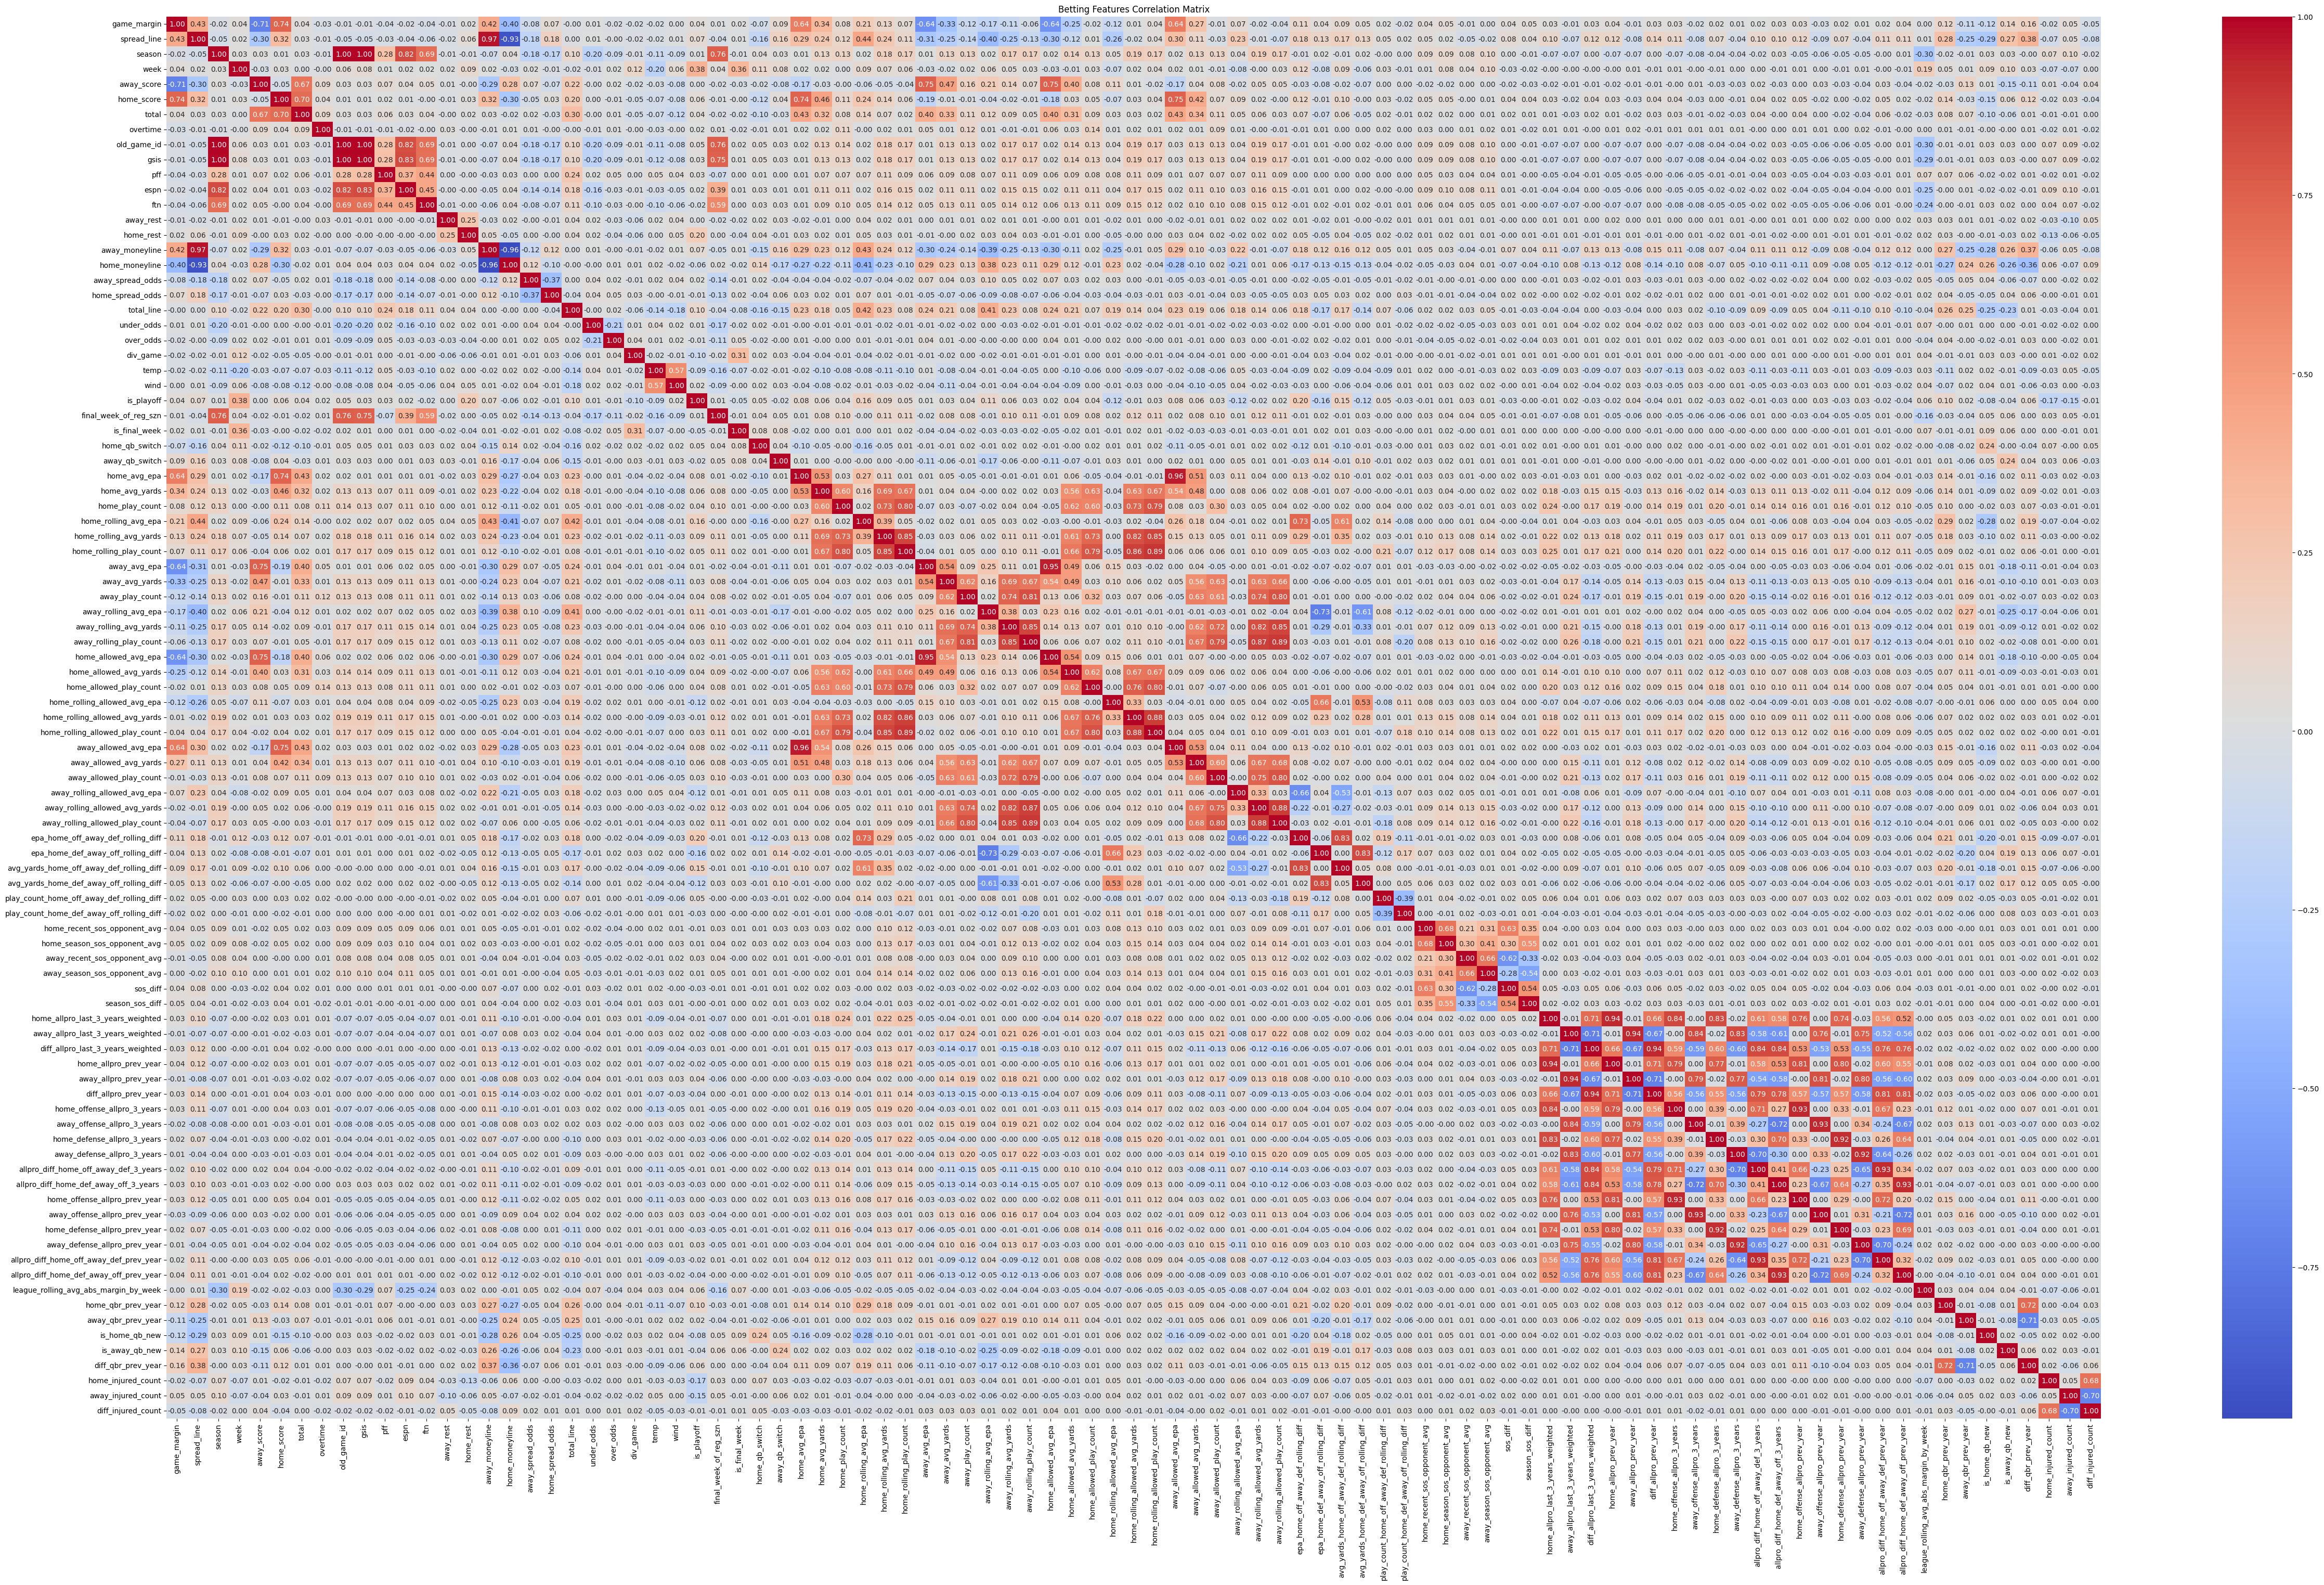

In [46]:
#correlation matrix -> core question: do any of the features in this dataset lead to high margin of victory for home team? or for away team? This is a pointless question as who wins the game would be due to many other factors.
#so would not take much away from this...nonetheless this is good to show for seeing what features might have collinearity.
#This also shows how regression may not be the best suited modeling technique for our project.

#although the recent team performance metrics are going to be correlated with winning or losing so that makes sense

corr_df = match_df.corr(numeric_only=True)
plt.figure(figsize=(60, 35))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Betting Features Correlation Matrix')
plt.show()

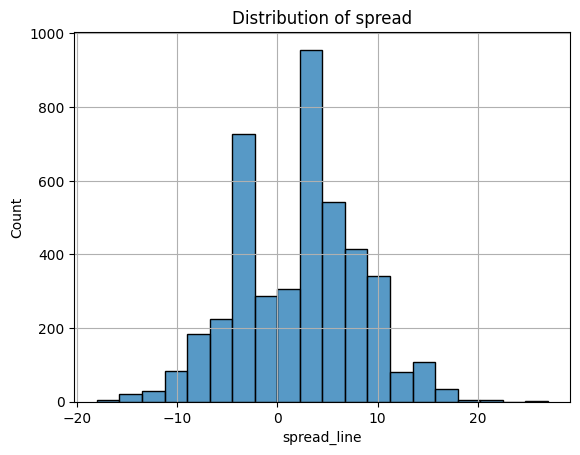

<Figure size 1500x1000 with 0 Axes>

In [47]:
#distribution of target variable. most spreads tend to be within 10 points of zero
sns.histplot(match_df['spread_line'], bins=20)
plt.grid(True)
plt.title('Distribution of spread')
plt.figure(figsize=(15, 10))
plt.show()

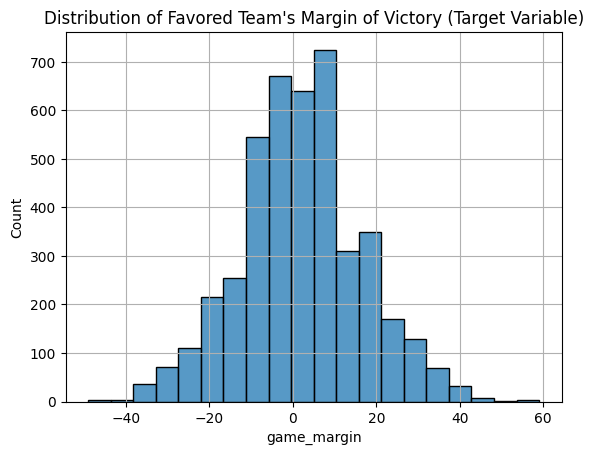

<Figure size 1500x1000 with 0 Axes>

In [48]:
#distribution of game_margin. most margins of victory are between 20 points of zero. As you can see margin of victory has a larger range compared to spread line
sns.histplot(match_df['game_margin'], bins=20)
plt.grid(True)
plt.title("Distribution of Favored Team's Margin of Victory (Target Variable)")
plt.figure(figsize=(15, 10))
plt.show()

In [49]:
# needs to match for features_df
match_df = match_df.rename(columns={'final_week_of_reg_szn': 'final_week'})
match_df.head()

game_id  game_margin  spread_line  season game_type  week  \
0  2009_01_TEN_PIT          3.0          6.5    2009       REG     1   
1  2009_01_MIA_ATL         12.0          4.0    2009       REG     1   
2   2009_01_KC_BAL         14.0         13.0    2009       REG     1   
3  2009_01_PHI_CAR        -28.0         -1.0    2009       REG     1   
4  2009_01_DEN_CIN         -5.0          4.5    2009       REG     1   

      gameday   weekday gametime away_team  away_score home_team  home_score  \
0  2009-09-10  Thursday    20:30       TEN        10.0       PIT        13.0   
1  2009-09-13    Sunday    13:00       MIA         7.0       ATL        19.0   
2  2009-09-13    Sunday    13:00        KC        24.0       BAL        38.0   
3  2009-09-13    Sunday    13:00       PHI        38.0       CAR        10.0   
4  2009-09-13    Sunday    13:00       DEN        12.0       CIN         7.0   

  location  total  overtime  old_game_id     gsis nfl_detail_id           pfr  \
0     Home   23.0       1.0   2009091000  54467.0             0  200909100pit   
1     Home   26.0       0.0   2009091300  54468.0             0  200909130atl   
2     Home   62.0       0.0   2009091301  54469.0             0  200909130rav   
3     Home   48.0       0.0   2009091302  54470.0             0  200909130car   
4     Home   19.0       0.0   2009091303  54471.0             0  200909130cin   

      pff         espn  ftn  away_rest  home_rest  away_moneyline  \
0  1395.0  290910023.0  0.0          7          7           228.0   
1  1396.0  290913001.0  0.0          7          7           190.0   
2  1398.0  290913033.0  0.0          7          7           570.0   
3  1404.0  290913029.0  0.0          7          7          -125.0   
4  1403.0  290913004.0  0.0          7          7           196.0   

   home_moneyline  away_spread_odds  home_spread_odds  total_line  under_odds  \
0          -260.0            -116.0             107.0        35.5      -106.0   
1          -210.0            -104.0            -104.0        44.0      -103.0   
2          -700.0            -112.0             104.0        36.5      -103.0   
3           115.0            -120.0             111.0        43.5      -103.0   
4          -222.0            -104.0            -104.0        41.0      -112.0   

   over_odds  div_game      roof     surface  temp  wind  away_qb_id  \
0     -104.0         0  outdoors  dessograss  67.0   9.0  00-0003292   
1     -107.0         0      dome   fieldturf   0.0   0.0  00-0019559   
2     -107.0         0  outdoors   sportturf  76.0   5.0  00-0024300   
3     -107.0         0  outdoors       grass  82.0   5.0  00-0011022   
4      102.0         0  outdoors   fieldturf  73.0   7.0  00-0023541   

   home_qb_id     away_qb_name        home_qb_name      away_coach  \
0  00-0022924    Kerry Collins  Ben Roethlisberger     Jeff Fisher   
1  00-0026143  Chad Pennington           Matt Ryan    Tony Sparano   
2  00-0026158    Brodie Croyle          Joe Flacco      Todd Haley   
3  00-0004161   Donovan McNabb       Jake Delhomme       Andy Reid   
4  00-0021429       Kyle Orton       Carson Palmer  Josh McDaniels   

      home_coach         referee stadium_id                  stadium  \
0    Mike Tomlin      Bill Leavy      PIT00              Heinz Field   
1     Mike Smith    Walt Coleman      ATL00             Georgia Dome   
2  John Harbaugh  Gene Steratore      BAL00         M&T Bank Stadium   
3       John Fox  Jeff Triplette      CAR00  Bank of America Stadium   
4   Marvin Lewis    Jerome Boger      CIN00       Paul Brown Stadium   

   is_playoff  final_week  is_final_week  home_qb_switch  away_qb_switch  \
0       False          17          False           False           False   
1       False          17          False           False           False   
2       False          17          False           False           False   
3       False          17          False           False           False   
4       False          17          False 

##Modeling

###Setup

To finish setting up our dataset, we only want matches played after weeks 1 and 2 since some of our features use previous recent game data. In addition, I am dropping any feature that is not predictive since it will not be beneficial for our model. Lastly, I am dropping any row that has a nan value in it for simplicity.

In [50]:
#drop columns that we are not using as features in the initial dataset, only take data after week 3 because we don't have rolling data before then that is very accurate

'''features_df = match_df[match_df['week'] >= 3][['game_margin', 'away_rest', 'home_rest', 'total_line', 'div_game', 'roof', 'surface', 'temp', 'wind', 'home_qb_name', 'away_qb_name', 'away_coach', 'home_coach', 'referee', 'stadium_id', 'is_playoff', 'is_final_week',
                                               'home_qb_switch', 'away_qb_switch', 'home_rolling_avg_epa', 'home_rolling_avg_yards', 'home_rolling_play_count', 'away_rolling_avg_epa', 'away_rolling_avg_yards', 'away_rolling_play_count', 'home_rolling_allowed_avg_epa',
                                               'home_rolling_allowed_avg_yards', 'home_rolling_allowed_play_count', 'away_rolling_allowed_avg_epa', 'away_rolling_allowed_avg_yards', 'away_rolling_allowed_play_count', 'home_off_away_def_rolling_epa_diff',
                                               'home_def_away_off_rolling_epa_diff', 'home_off_away_def_rolling_avg_yards_diff', 'home_def_away_off_rolling_avg_yards_diff', 'home_off_away_def_rolling_play_count_diff', 'home_def_away_off_rolling_play_count_diff',
                                               'sos_diff','season_sos_diff', 'home_allpro_last_3_years_weighted', 'away_allpro_last_3_years_weighted', 'diff_allpro_last_3_years_weighted', 'home_allpro_prev_year', 'away_allpro_prev_year', 'diff_allpro_prev_year','diff_offense_allpro_3_years',
                                               'diff_defense_allpro_3_years', 'home_offense_vs_away_defense_3_years', 'home_defense_vs_away_offense_3_years', 'diff_offense_allpro_prev_year', 'diff_defense_allpro_prev_year', 'home_offense_vs_away_defense_prev_year',
                                               'home_defense_vs_away_offense_prev_year' ]]'''

print("Total data before dropping weeks 1-2 in seasons:")
print(match_df.shape)
print('\n\n')

# added this to keep conistent with week 3 start
match_df = match_df[match_df['week'] >= 3]

#print(features_df.shape)

#change to features_df
features_df = match_df.drop(['game_id', 'week', 'season', 'game_type', 'gameday', 'weekday', 'gametime', 'away_team', 'home_team', 'spread_line', 'away_score', 'home_score', 'location', 'total', 'overtime', 'old_game_id', 'gsis', 'nfl_detail_id', 'pfr', 'pff', 'espn', 'ftn',
                             'away_moneyline', 'home_moneyline', 'away_spread_odds', 'home_spread_odds', 'under_odds', 'over_odds', 'stadium', 'final_week', 'away_qb_id', 'home_qb_id', 'home_avg_epa', 'home_avg_yards', 'home_play_count', 'away_avg_epa', 'away_avg_yards', 'away_play_count',
                             'home_allowed_avg_epa', 'home_allowed_avg_yards', 'home_allowed_play_count', 'away_allowed_avg_epa', 'away_allowed_avg_yards', 'away_allowed_play_count', 'home_qb_name', 'away_qb_name', 'away_coach', 'home_coach', 'referee', 'stadium_id'], axis=1)

print('total data after dropping weeks 1-2 in seasons and before dropping nan values:')
print(features_df.shape)
print('\n\n')

#drop nan values for any feature
features_df = features_df.dropna()

print('Total data after droppping nan values')
print(features_df.shape)



features_df

Total data before dropping weeks 1-2 in seasons:
(4345, 114)



total data after dropping weeks 1-2 in seasons and before dropping nan values:
(3834, 64)



Total data after droppping nan values
(3834, 64)


game_margin  away_rest  home_rest  total_line  div_game      roof  \
32           31.0          7          7        38.5         1  outdoors   
33            5.0          7          7        39.5         0      dome   
34           -7.0          7          7        47.0         1    closed   
35            3.0          7          7        39.0         0      dome   
36           16.0          7          7        45.5         0  outdoors   
...           ...        ...        ...         ...       ...       ...   
4340          6.0          6          7        43.5         0  outdoors   
4341          2.0          8          7        51.5         0  outdoors   
4342         32.0          8          7        46.5         1  outdoors   
4343          3.0          7          8        49.5         0  outdoors   
4344         18.0         14         14        48.5         0      dome   

        surface  temp  wind  is_playoff  is_final_week  home_qb_switch  \
32    sportturf  72.0   6.0       False          False           False   
33    fieldturf   0.0   0.0       False          False           False   
34        grass   0.0   0.0       False          False           False   
35    fieldturf   0.0   0.0       False          False           False   
36    fieldturf  62.0   0.0       False          False           False   
...         ...   ...   ...         ...            ...             ...   
4340      grass  34.0   8.0        True          False           False   
4341     a_turf  19.0   4.0        True          False           False   
4342      grass  40.0  11.0        True          False           False   
4343      grass  31.0   8.0        True          False           False   
4344  sportturf   0.0   0.0        True          False           False   

      away_qb_switch  home_rolling_avg_epa  home_rolling_avg_yards  \
32             False              0.139008                5.538726   
33             False             -0.230076                4.042664   
34             False             -0.084081                5.103220   
35             False              0.089624                5.036366   
36             False             -0.021698                5.022482   
...              ...                   ...                     ...   
4340           False              0.100234                5.266704   
4341           False              0.188274                6.109140   
4342           False              0.077039                5.350217   
4343           False             -0.004269                4.823622   
4344           False              0.151505                5.819643   

      home_rolling_play_count  away_rolling_avg_epa  away_rolling_avg_yards  \
32                       72.5             -0.281558                4.060606   
33                       61.5             -0.054802                5.451343   
34                       57.0             -0.092676                4.811834   
35                       57.5             -0.015240                4.850000   
36                       73.0              0.044920                5.196825   
...                       ...                   ...                     ...   
4340                     65.4              0.009015                5.366755   
4341                     64.0              0.277911                7.034257   
4342                     62.6              0.128645                5.663357   
4343                     56.0              0.107830                5.402410   
4344                     61.4              0.065030                5.189039   

      away_rolling_play_count  home_rolling_allowed_avg_epa  \
32                       57.5                     -0.050452   
33                       58.5                      0.106783   
34                       61.5                      0.116157   
35                       60.0                     -0.217014   
36                       63.0                      0.035473   
...                       ...                   

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, make_scorer, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

###Random Forest Regressor - Initial Model

We decided to use a random forest regressor because it handles nonlinear data well, works well with a broad range of features, is good with overfitting, and allows for feature importance.

The goal of this initial RF Regressor Model is to reduce the features that we are using in future models and further in our project. Right now we are using too many features and need to hone down on more influential features that impact game margin.

In the initial run through, the goal is not to have an incredibly well performing model.

Sources

https://www.geeksforgeeks.org/machine-learning/categorical-data-encoding-techniques-in-machine-learning/

https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html

In [ ]:
def random_forest_regressor_v1(features_df, model_depth=None, threshold=.5):

    #features
    X = features_df.drop(columns='game_margin')
    #target variable
    y = features_df['game_margin']

    #random forest model only works with numbers so we need to encode categorical features into a number of some sort
    #Using One Hot Encoding because while none of the categorical variables have an order to them we don't want the model to pick up any 'fake ordering'

    #converts each category to binary value
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
    quan_features = [col for col in X.columns if col not in cat_features]

    #checks categorical columns are all strings
    X[cat_features] = X[cat_features].astype(str)

    print("Number of Features:")
    print(len(quan_features) + len(cat_features))
    print('\n\n')
    print("Name of Features - Categorical and Quantative Respectively:")
    print(cat_features)
    print('\n\n')
    print(quan_features)
    print('\n\n')

    #encode categorical features
    cat_feature_encoding = ColumnTransformer([("cat_features", OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)], remainder='passthrough')

    X_encoded = cat_feature_encoding.fit_transform(X)
    new_cat_feat_names = cat_feature_encoding.named_transformers_['cat_features'].get_feature_names_out(cat_features)
    updated_feats = list(new_cat_feat_names) + list(quan_features)
    X_updated = pd.DataFrame(X_encoded, columns=updated_feats)
    X_updated = X_updated.astype(float)

    print("Features After Encoding:")
    print(X_updated.columns)
    print('\n\n')

    X_train, X_test, y_train, y_test = train_test_split(X_updated, y, test_size=0.2, random_state=3)

    rf_reg = RandomForestRegressor(n_estimators=100, random_state=3, max_depth=model_depth)
    rf_reg.fit(X_train, y_train)

    train_pred = rf_reg.predict(X_train)
    test_pred = rf_reg.predict(X_test)

    print("TRAIN MAE:")
    print(mean_absolute_error(y_train, train_pred))
    print('\n\n')

    print("TRAIN R²:")
    print(r2_score(y_train, train_pred))
    print('\n\n')

    print("TEST MAE:")
    print(mean_absolute_error(y_test, test_pred))
    print('\n\n')

    print("TEST R²:")
    print(r2_score(y_test, test_pred))
    print('\n\n')

    #Calculating the feature importance
    feature_importance = rf_reg.feature_importances_
    feature_importance = 100.0*(feature_importance/np.sum(feature_importance))

    #Get top 20 feature since there are so many
    top_x = 20
    top_idx = np.argsort(feature_importance)[-top_x:]
    top_idx = top_idx[np.argsort(feature_importance[top_idx])[::-1]]

    updated_feats_arr = np.array(updated_feats)
    top_features = updated_feats_arr[top_idx]

    print(top_features)
    print('\n\n')
    top_importance = feature_importance[top_idx]
    print(top_importance)
    print('\n\n')

    #plotting the top 20 features for my random forest regressor
    plt.figure(figsize=(10, 10))
    plt.barh(np.arange(top_x), top_importance[::-1], color='crimson', align='center')
    plt.yticks(np.arange(top_x), top_features[::-1])
    plt.xlabel('Relative Importance (%)')
    plt.title('RF Reg - Feature Importance - Top 20 Features')
    plt.tight_layout()
    plt.show()

    #drop low importance features and return updated df
    low_idx = np.where(feature_importance < threshold)[0]
    low_feat_names = np.array(updated_feats)[low_idx].tolist()

    print('\n\n')
    print(f"{len(low_feat_names)} features with importance < {threshold}%")
    print('\n\n')

    #drop low importance features from encoded X
    X_filtered = X_updated.drop(columns=low_feat_names)

    print("len of features above threshold:")
    print(len(X_filtered.columns))
    print('\n\n')

    # Combine with y and return
    updated_df = pd.concat([X_filtered, y.reset_index(drop=True)], axis=1)
    return rf_reg, updated_df, low_feat_names


Number of Features:
63



Name of Features - Categorical and Quantative Respectively:
['roof', 'surface']



['away_rest', 'home_rest', 'total_line', 'div_game', 'temp', 'wind', 'is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'home_rolling_avg_epa', 'home_rolling_avg_yards', 'home_rolling_play_count', 'away_rolling_avg_epa', 'away_rolling_avg_yards', 'away_rolling_play_count', 'home_rolling_allowed_avg_epa', 'home_rolling_allowed_avg_yards', 'home_rolling_allowed_play_count', 'away_rolling_allowed_avg_epa', 'away_rolling_allowed_avg_yards', 'away_rolling_allowed_play_count', 'epa_home_off_away_def_rolling_diff', 'epa_home_def_away_off_rolling_diff', 'avg_yards_home_off_away_def_rolling_diff', 'avg_yards_home_def_away_off_rolling_diff', 'play_count_home_off_away_def_rolling_diff', 'play_count_home_def_away_off_rolling_diff', 'home_recent_sos_opponent_avg', 'home_season_sos_opponent_avg', 'away_recent_sos_opponent_avg', 'away_season_sos_opponent_avg', 'sos_diff', 'seas

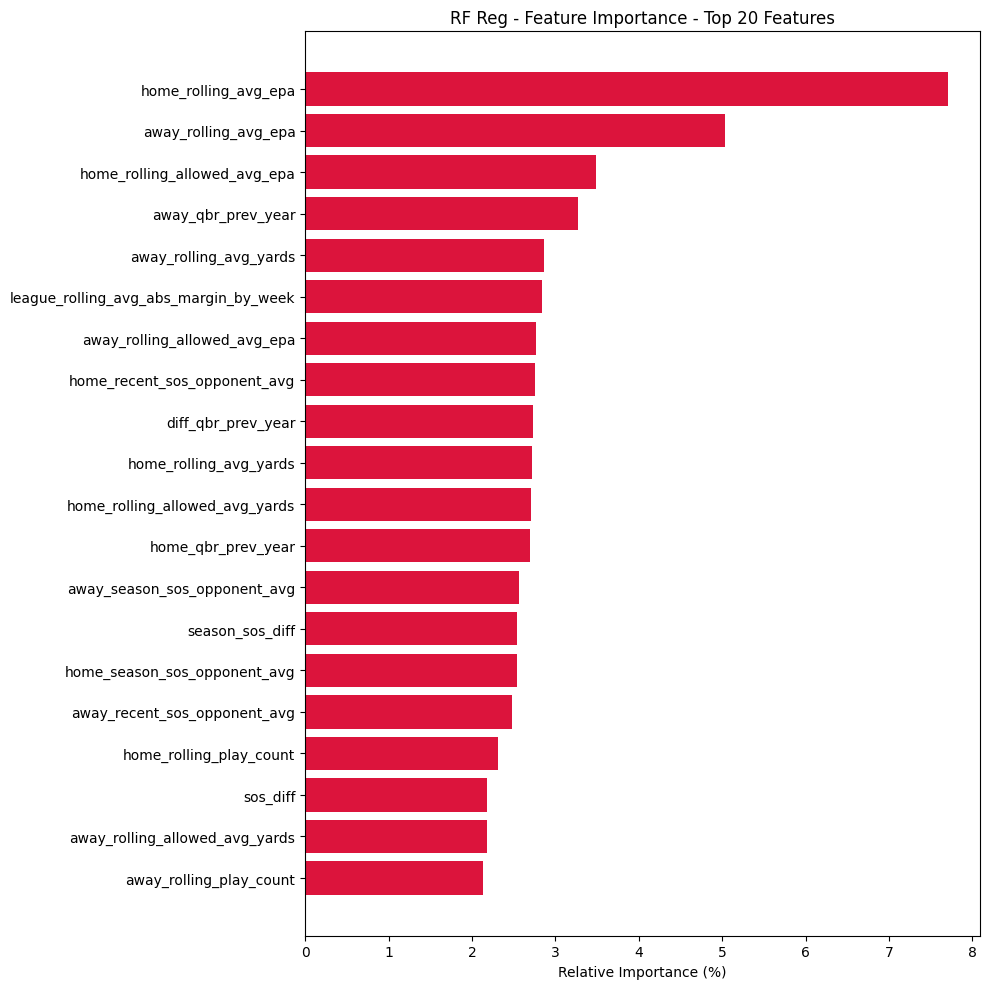




28 features with importance < 0.5%



len of features above threshold:
47





In [ ]:
init_model = random_forest_regressor_v1(features_df)

As you can see we are overfitting heavily. This is due to not having any hyperparams to stop depth and feature redundance.

Even still the MAE for our model is 10.58 which means, on average, our model predicted a game margin off by approximately 10.58 points from the real value.

Typically, NFL game margins are single digit. This means we are performing worse than just predicting the mean margin. NFL games are noisy. Game margins can vary heavily by just one play.

An R-squared score of 9.75% means our model explains 9.75% of the variance in game margin. This is low, but not unexpected as the NFL and sports in general are very noisy.

The most important features for our model our shown above. EPA seems to be the most important feature(s) by far.

Model minimized error based on the features given. Shows which features are important overall.

Based off our model and feature importance report:

Drop the bottom features (those with near-zero importance). Hopefully this will lessen overfitting and increase generalization.

After encoding we had 75 features. Only 47 of those had a feature importance above .5%.

Multicollinearity is ok, but can still reduce redundancy in feature set.

Focus and refine on top 5 to 10 features. Fully flesh out those features in whatevery ways necessary.

Looking at feature importance from other models can give us a good understanding of commonality in features among them.

###2nd Interation of RF Regressor

For instance, one thing adjusted after an initial look at the model is combining rolling epa, rolling avg yards, and rolling play count of away and home teams into a two differential feature for each category. One differential is home offense vs away defense. The other is away offense vs home defense.

We also combined some other away vs home team features into diff features to reduce feature count.

This should clear up clutter and reduce high correlation between features.

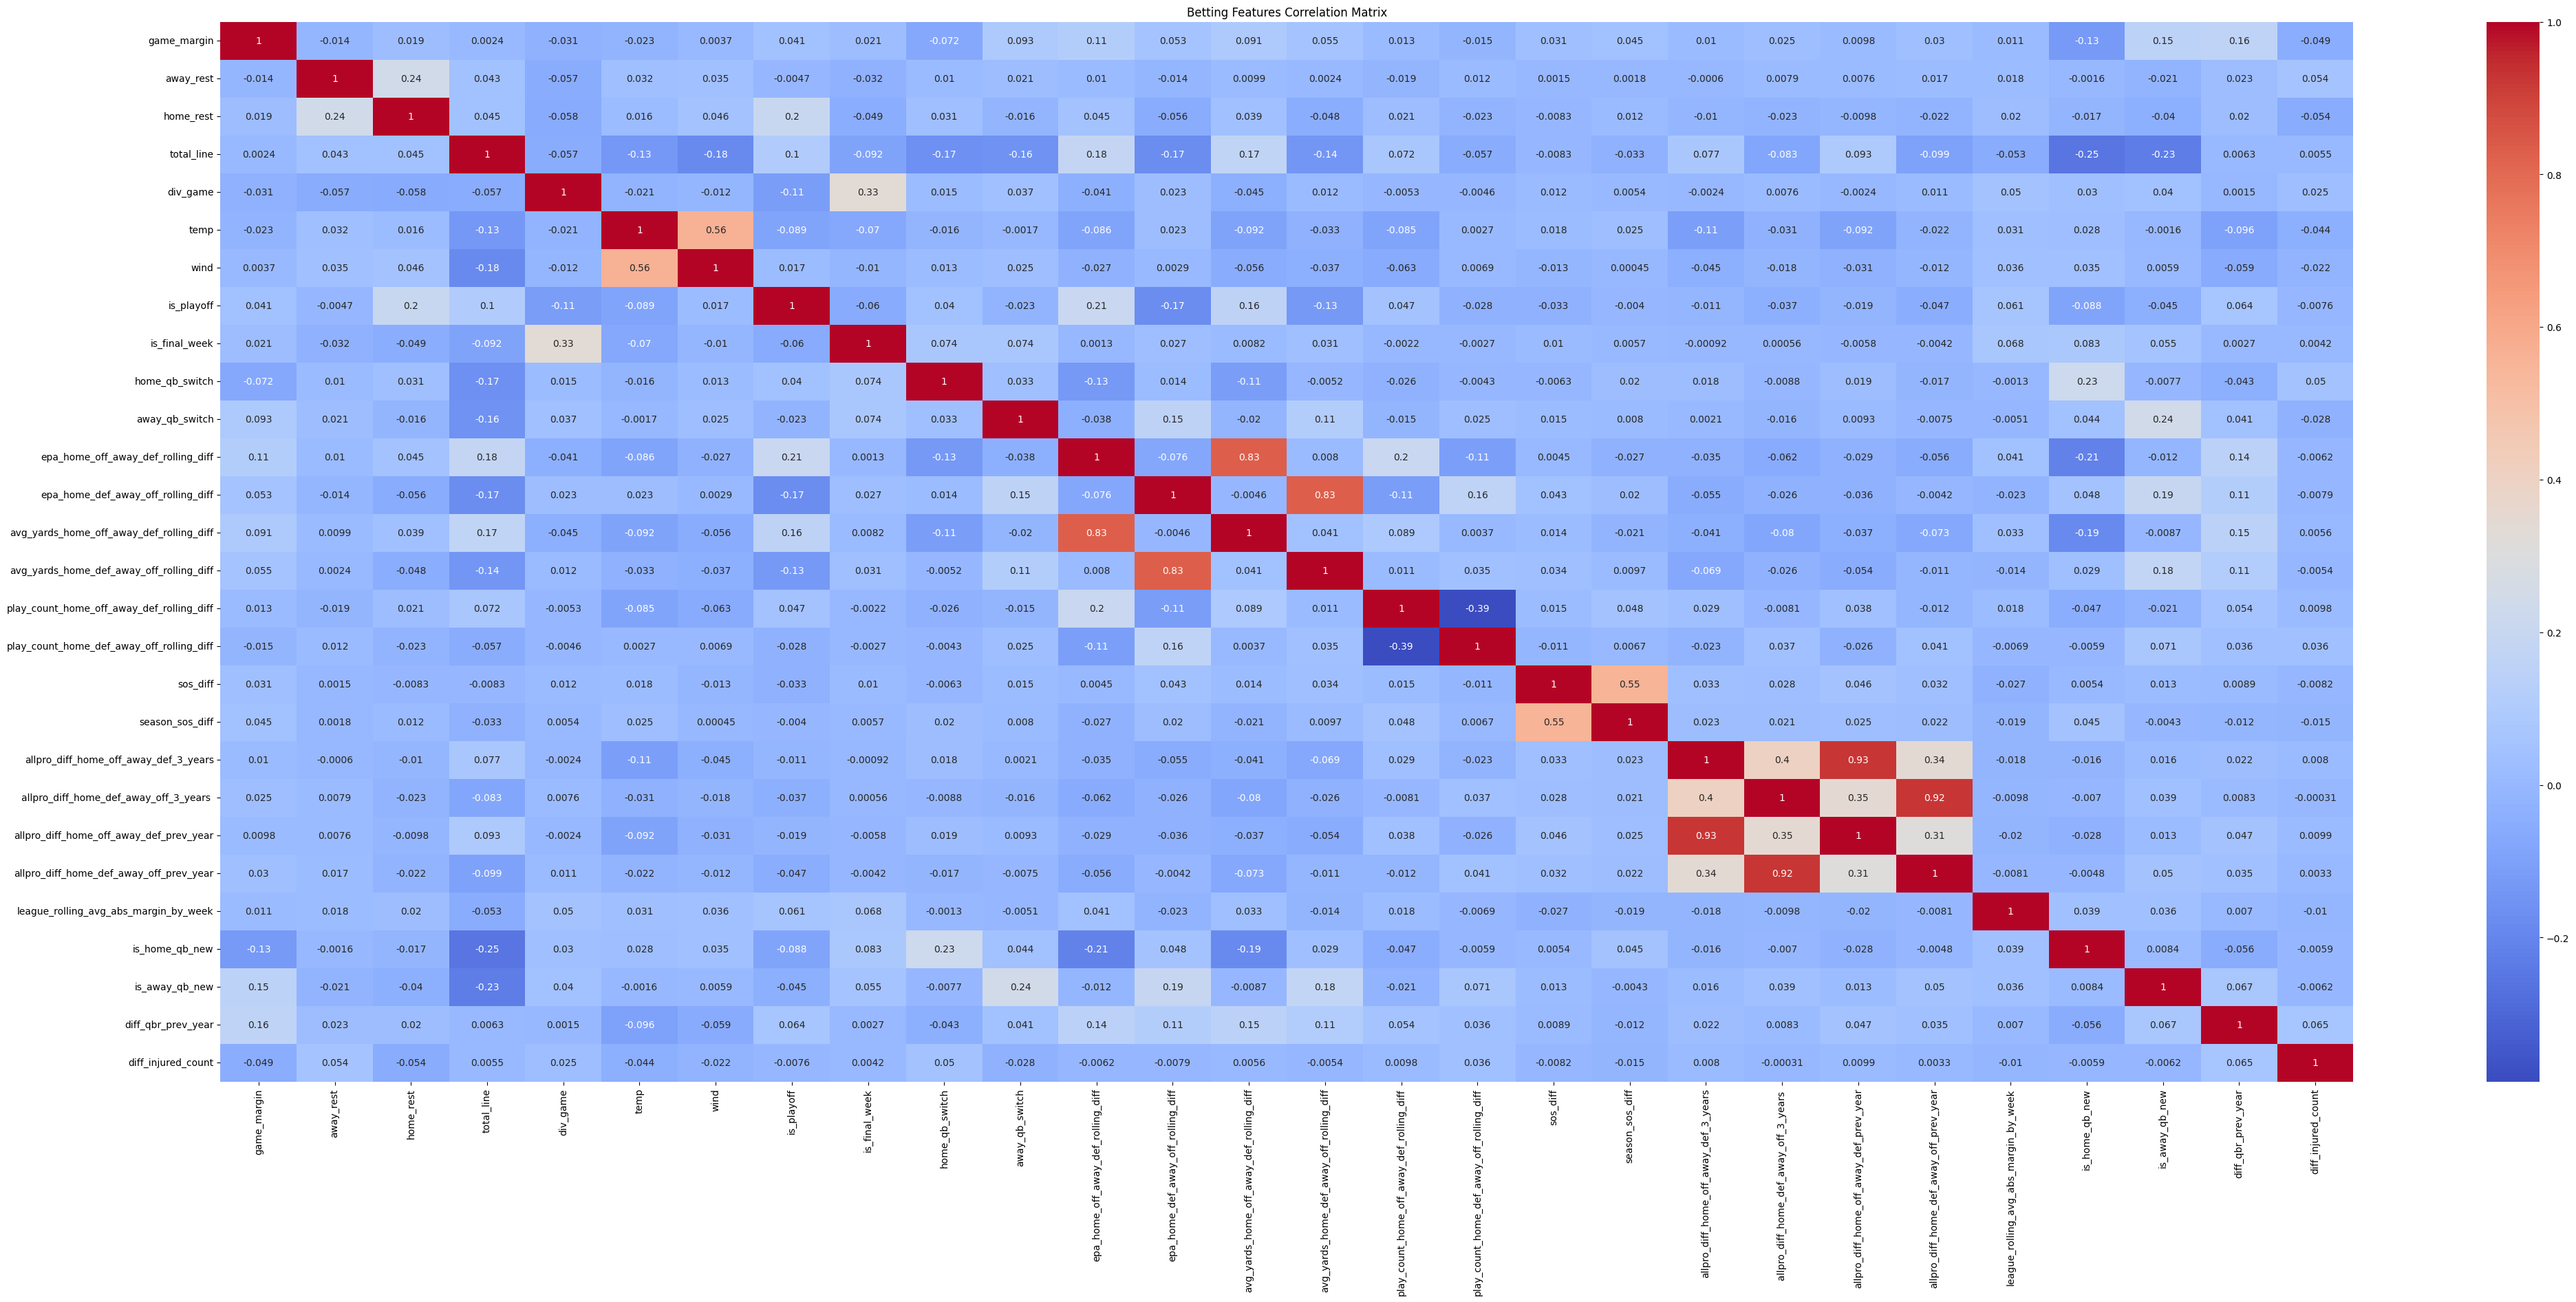

In [ ]:
#after RF regressor, updating features to combine epa, avg yards, and play count (home off vs away def and home def vs away off)

#removing redundant features - keeping diffs
reduced_features_df = features_df.drop(['home_rolling_avg_epa', 'home_rolling_avg_yards', 'home_rolling_play_count',
                                        'away_rolling_avg_epa', 'away_rolling_avg_yards', 'away_rolling_play_count',
                                        'home_rolling_allowed_avg_epa', 'home_rolling_allowed_avg_yards', 'home_rolling_allowed_play_count',
                                        'away_rolling_allowed_avg_epa', 'away_rolling_allowed_avg_yards', 'away_rolling_allowed_play_count',
                                        'home_recent_sos_opponent_avg', 'home_season_sos_opponent_avg', 'away_recent_sos_opponent_avg', 'away_season_sos_opponent_avg',
                                        'home_allpro_last_3_years_weighted', 'away_allpro_last_3_years_weighted', 'diff_allpro_last_3_years_weighted', 'home_allpro_prev_year', 'away_allpro_prev_year', 'diff_allpro_prev_year',
                                        'home_offense_allpro_3_years', 'away_offense_allpro_3_years', 'home_defense_allpro_3_years', 'away_defense_allpro_3_years',
                                        'home_offense_allpro_prev_year', 'away_offense_allpro_prev_year', 'home_defense_allpro_prev_year', 'away_defense_allpro_prev_year',
                                        'home_qbr_prev_year', 'away_qbr_prev_year', 'home_injured_count', 'away_injured_count'], axis=1)

#will need to remove features that are highly correlated
corr_df = reduced_features_df.corr(numeric_only=True)
plt.figure(figsize=(50, 20))
sns.heatmap(corr_df, annot=True, cmap='coolwarm')
plt.title('Betting Features Correlation Matrix')
plt.show()

**Multicollinearity hurts linear models, not trees.**

these are some of our main qualitative features in a heatmap for context after reducing feature set

We went from 61 features to 31 features. Of course with encoding we are still at 1110.



Number of Features:
29



Name of Features - Categorical and Quantative Respectively:
['roof', 'surface']



['away_rest', 'home_rest', 'total_line', 'div_game', 'temp', 'wind', 'is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch', 'epa_home_off_away_def_rolling_diff', 'epa_home_def_away_off_rolling_diff', 'avg_yards_home_off_away_def_rolling_diff', 'avg_yards_home_def_away_off_rolling_diff', 'play_count_home_off_away_def_rolling_diff', 'play_count_home_def_away_off_rolling_diff', 'sos_diff', 'season_sos_diff', 'allpro_diff_home_off_away_def_3_years', 'allpro_diff_home_def_away_off_3_years ', 'allpro_diff_home_off_away_def_prev_year', 'allpro_diff_home_def_away_off_prev_year', 'league_rolling_avg_abs_margin_by_week', 'is_home_qb_new', 'is_away_qb_new', 'diff_qbr_prev_year', 'diff_injured_count']



Features After Encoding:
Index(['roof_closed', 'roof_dome', 'roof_open', 'roof_outdoors', 'surface_0',
       'surface_a_turf', 'surface_astroplay', 'surface_astroturf',
       

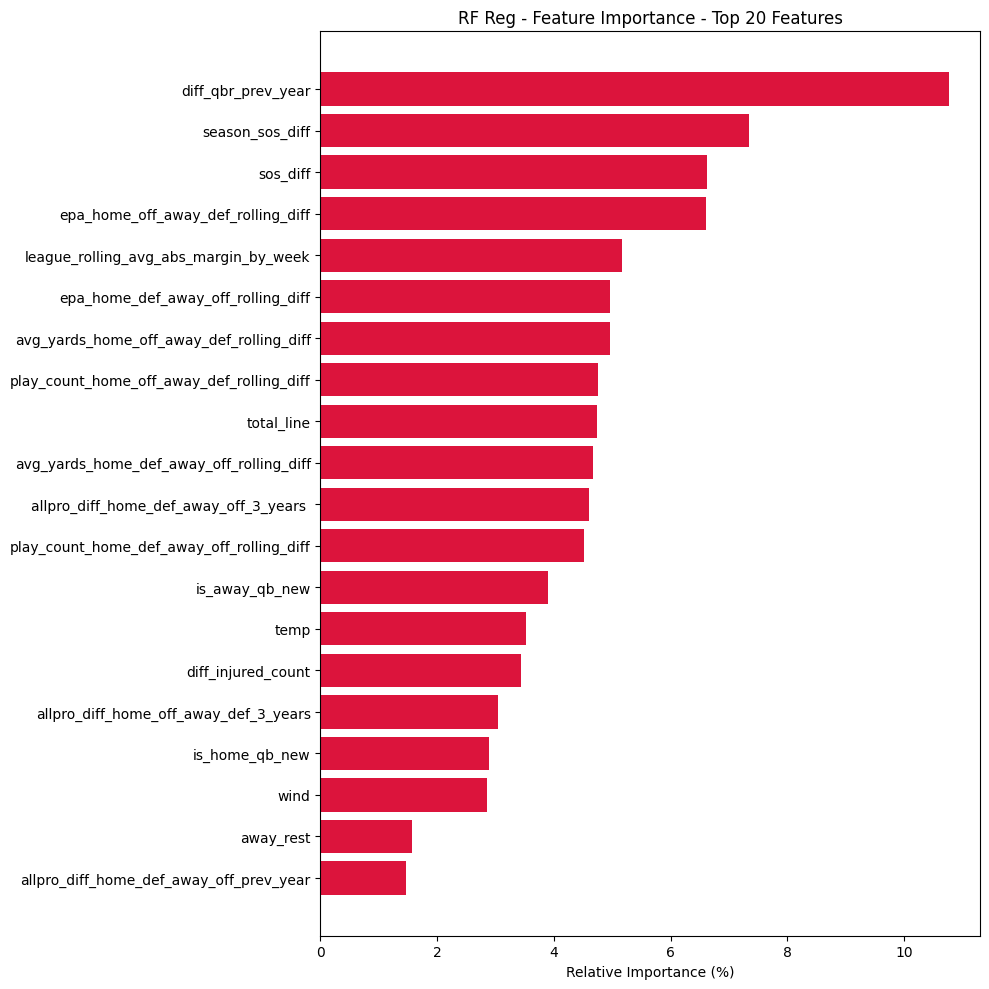




19 features with importance < 1%



len of features above threshold:
22





In [ ]:
#all pro prev year mae = 10.63. r2 = .0903, all pro last 3 years weighted mae = 10.66, r2 = .0803 -> keep all pro prev year
#no_corr_features = reduced_features_df.drop(['diff_home_def_away_off_prev_year', 'diff_home_off_away_def_prev_year'], axis=1)

rf_reg, updated_df, dropped_features = random_forest_regressor_v1(reduced_features_df, model_depth=10, threshold=1)

Now we have 41 features after encoding.

We added depth to our model making our test evaluation much closer to our train evaluation. This is a good sign in reduction of overfitting. It is still performing lower than I had hoped though.

The MAE for our model is 10.76 which means, on average, our model predicted a game margin off by approximately 10.76 points from the real value.

Better than our previous model.

An R-squared score of 8.25% means our model explains 8.25% of the variance in game margin. This is a slight decrease from the previous model.

Hard to take much away as collinearity can actually help random forest models by removing noise.

By looking at our feature importance, it looks a lot more diverse after combining some of the highly correlated features. This is good for a more genearlized model moving further into our project.

22 features had a feature importance above 1%.

Next, we can improve the feature set even further if we remove the bottom features.

###3rd iteration

source - https://scikit-learn.org/stable/modules/grid_search.html

Using grid search to help find good hyperparams - takes a long time so i did one hyperparam at a time.

In [ ]:
def random_forest_regressor_v2(features_df):

    #features
    X = features_df.drop(columns='game_margin')
    #target variable
    y = features_df['game_margin']

    X_updated = X.astype(float)

    print("Number of features:")
    print(len(X_updated.columns))
    print('\n\n')
    print("Name of features:")
    print(X_updated.columns)
    print('\n\n')

    X_train, X_test, y_train, y_test = train_test_split(X_updated, y, test_size=0.2, random_state=3)
    rf_reg = RandomForestRegressor(random_state=42)

    #grid search
    grid = {
        'n_estimators': [500],
        'max_depth': [10],
        'min_samples_split': [175], #175
        'min_samples_leaf': [40], #40
        'max_features': [None],
        'criterion': ['absolute_error']
    }

    gs = GridSearchCV(estimator=rf_reg, param_grid=grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=2)
    gs.fit(X_train, y_train)

    grid_model = gs.best_estimator_
    print("\nBest hyperparameters:")
    print(gs.best_params_)

    print(f"\n\nBest CV MAE: {-gs.best_score_:.4f}")

    #rf_reg = RandomForestRegressor(n_estimators=100, random_state=3, max_depth=model_depth)
    #rf_reg.fit(X_train, y_train)

    test_pred = grid_model.predict(X_test)
    train_pred = grid_model.predict(X_train)

    #train_pred = rf_reg.predict(X_train)
    #test_pred = rf_reg.predict(X_test)
    print('\n\n')
    print("TRAIN MAE:")
    print(mean_absolute_error(y_train, train_pred))
    print('\n\n')

    print("TRAIN R²:")
    print(r2_score(y_train, train_pred))
    print('\n\n')

    print("TEST MAE:")
    print(mean_absolute_error(y_test, test_pred))
    print('\n\n')

    print("TEST R²:")
    print(r2_score(y_test, test_pred))
    print('\n\n')

    #cross validation - takes really long and not neccesary for now
    '''cv_mae_pred = cross_val_score(rf_reg, X_updated, y, cv=5, scoring='neg_mean_absolute_error')
    cv_mae_pred = -cv_mae_pred
    print(f"Cross-validated MAE scores: {cv_mae_pred}")
    print(f"Mean CV MAE: {cv_mae_pred.mean():.3f}")

    cv_r2_pred = cross_val_score(rf_reg, X_updated, y, cv=5, scoring='r2')
    print(f"Cross-validated R² scores: {cv_r2_pred}")
    print(f"Mean CV R²: {cv_r2_pred.mean():.3f}")'''

    #Calculating the feature importance
    feature_importance = grid_model.feature_importances_
    feature_importance = 100.0*(feature_importance/np.sum(feature_importance))

    #Get top 20 feature since there are so many
    '''top_x = 20
    top_idx = np.argsort(feature_importance)[-top_x:]
    top_idx = top_idx[np.argsort(feature_importance[top_idx])[::-1]]

    updated_feats_arr = np.array(X_updated.columns)
    top_features = updated_feats_arr[top_idx]

    print(top_features)
    print('\n\n')
    top_importance = feature_importance[top_idx]
    print(top_importance)
    print('\n\n')

    #plotting the top 20 features for my random forest regressor
    plt.figure(figsize=(10, 10))
    plt.barh(np.arange(top_x), top_importance[::-1], color='crimson', align='center')
    plt.yticks(np.arange(top_x), top_features[::-1])
    plt.xlabel('Relative Importance (%)')
    plt.title('RF Reg - Feature Importance - Top 20 Features')
    plt.tight_layout()
    plt.show()'''

    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)[::-1]
    features = np.array(X_updated.columns)[sorted_idx]
    imp = feature_importance[sorted_idx]

    '''print("Top Features by Importance:")
    for name, score in zip(features, imp):
        print(f"{name}: {score:.2f}%")'''

    print('\n\n')

    # Plot all feature importances
    plt.figure(figsize=(12, max(6, 0.25 * len(features))))  # dynamic height
    plt.barh(np.arange(len(features)), imp[::-1], color='crimson', align='center')
    plt.yticks(np.arange(len(features)), features[::-1])
    plt.xlabel('Relative Importance (%)')
    plt.title('RF Regressor - Feature Importance')
    plt.tight_layout()
    plt.show()

    return grid_model

    #drop low importance features and return updated df
    '''low_idx = np.where(feature_importance < threshold)[0]
    low_feat_names = np.array(X_updated.columns)[low_idx].tolist()

    print('\n\n')
    print(f"{len(low_feat_names)} features with importance < {threshold}%")
    print('\n\n')

    #drop low importance features from encoded X
    X_filtered = X_updated.drop(columns=low_feat_names)
    print("len of features above threshold:")
    print(len(X_filtered.columns))
    print('\n\n')

    # Combine with y and return
    updated_df = pd.concat([X_filtered, y.reset_index(drop=True)], axis=1)
    return rf_reg, updated_df, low_feat_names'''

I want to add some hyperparameters to improve performance.

Number of features:
22



Name of features:
Index(['away_rest', 'home_rest', 'total_line', 'temp', 'wind',
       'epa_home_off_away_def_rolling_diff',
       'epa_home_def_away_off_rolling_diff',
       'avg_yards_home_off_away_def_rolling_diff',
       'avg_yards_home_def_away_off_rolling_diff',
       'play_count_home_off_away_def_rolling_diff',
       'play_count_home_def_away_off_rolling_diff', 'sos_diff',
       'season_sos_diff', 'allpro_diff_home_off_away_def_3_years',
       'allpro_diff_home_def_away_off_3_years ',
       'allpro_diff_home_off_away_def_prev_year',
       'allpro_diff_home_def_away_off_prev_year',
       'league_rolling_avg_abs_margin_by_week', 'is_home_qb_new',
       'is_away_qb_new', 'diff_qbr_prev_year', 'diff_injured_count'],
      dtype='object')



Fitting 5 folds for each of 1 candidates, totalling 5 fits

Best hyperparameters:
{'criterion': 'absolute_error', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 40, 'min_samples_split': 175, 'n_est

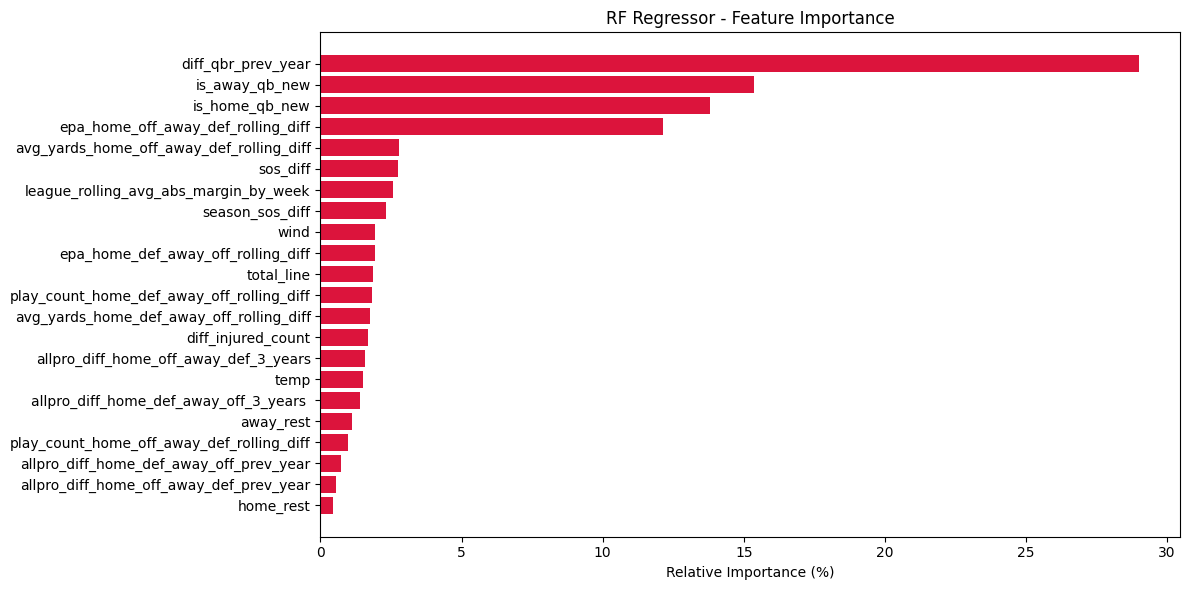

RandomForestRegressor(criterion='absolute_error', max_depth=5,
                      max_features=None, min_samples_leaf=40,
                      min_samples_split=175, n_estimators=500, random_state=42)

In [ ]:
#after RF regressor, updating features to combine epa, avg yards, and play count (home off vs away def and home def vs away off)
#NEEDED TO CREATE NEW FUNCTION THAT DOES NOT HAVE ENCODING CODE SINCE I ALREADY HAVE THOSE FEATURES IN MY DF FROM LAST ITERATION
random_forest_regressor_v2(updated_df)

When we filter for only features that were above 1 feature importance for our model in the previous feature set we got 22 features that were used here.

The MAE for our model is 11.17 which means, on average, our model predicted a game margin off by approximately 11.17 points from the real value.

An R-squared score of 5% means our model explains 5% of the variance in game margin. This is a significant decrease from the previous model.

Our feature reduction and hyperparamter tuning is in good shape.

it seems our feature set may be the limiting factor. I have tested extensively with various hyperparameter and feature combinations. We have greatly improved the overfitting issue at least. The model is still struggling to improve at all though.

The feature importance is interesting though, diving deeper into a away qb vs home qb comparison may be a good idea.



###XGBoost Model

In [68]:
# Define your features and target
X = features_df.drop(columns=['game_margin'])
y = features_df['game_margin']

# Updated categorical and boolean columns based on new match_df
categorical_cols = ['roof', 'surface']
boolean_cols = [
    'is_playoff', 'is_final_week',
    'home_qb_switch', 'away_qb_switch',
    'is_home_qb_new', 'is_away_qb_new'
]

# Automatically infer numerical columns
numerical_cols = [col for col in X.columns if col not in categorical_cols + boolean_cols]

# Ensure all categorical columns are strings (only if they exist in X)
for col in categorical_cols:
    if col in X.columns:
        X[col] = X[col].astype(str)


In [69]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pandas as pd

# --- Feature categories ---
categorical_cols = ['roof', 'surface']

# Updated boolean columns based on new match_df
boolean_cols = [
    'is_playoff', 'is_final_week',
    'home_qb_switch', 'away_qb_switch',
    'is_home_qb_new', 'is_away_qb_new'
]

# Automatically determine numerical columns
numerical_cols = [col for col in X.columns if col not in categorical_cols + boolean_cols]

# --- Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols + boolean_cols)
    ]
)

# --- XGBoost pipeline ---
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        max_depth=10,
        learning_rate=0.03,
        min_child_weight=1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        verbosity=1
    ))
])

# --- Train/Test split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Train model ---
pipeline.fit(X_train, y_train)

# --- Predict and evaluate ---
preds = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"MAE: {mae:.2f}, R²: {r2:.2f}")


MAE: 11.00, R²: 0.10


In [54]:
# Predict on train and test sets
train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)

# Evaluate R² for both
train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)

print(f"Train R²: {train_r2:.2f}")
print(f"Test R²: {test_r2:.2f}")


Train R²: 1.00
Test R²: 0.10


Overfitting from train data

In [55]:
# cross validation

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score

r2_scores = cross_val_score(pipeline, X, y, cv=5, scoring=make_scorer(r2_score))
print(f"Mean CV R²: {r2_scores.mean():.2f}")


Mean CV R²: 0.08


                                   feature  importance
60                          away_qb_switch    0.042113
59                          home_qb_switch    0.038484
62                          is_away_qb_new    0.036342
61                          is_home_qb_new    0.024615
53                      diff_qbr_prev_year    0.022235
8                     home_rolling_avg_epa    0.021618
52                      away_qbr_prev_year    0.020600
45           away_offense_allpro_prev_year    0.020445
56                      diff_injured_count    0.019372
40             home_defense_allpro_3_years    0.019358
11                    away_rolling_avg_epa    0.018929
14            home_rolling_allowed_avg_epa    0.018676
44           home_offense_allpro_prev_year    0.018221
43  allpro_diff_home_def_away_off_3_years     0.017977
36                   away_allpro_prev_year    0.017677


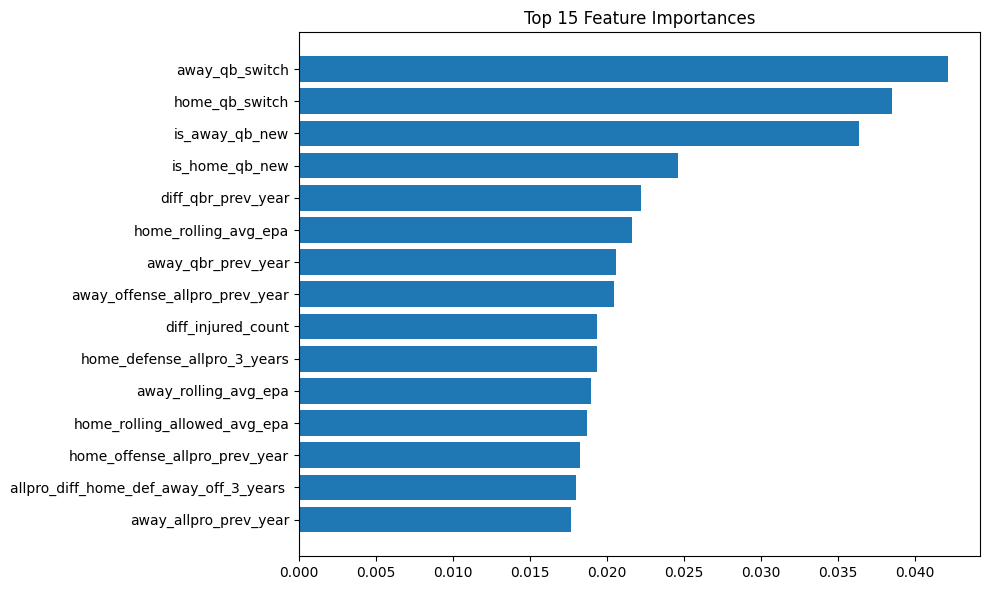

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Get trained XGBoost model
xgb_model = pipeline.named_steps['regressor']

# Get encoded feature names
cat_feats = pipeline.named_steps['preprocessor'].transformers_[0][2]
num_feats = numerical_cols + boolean_cols
feature_names = list(cat_feats) + num_feats

# Build importances DataFrame
importances_df = pd.DataFrame({
    'feature': feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

# Show top 15
print(importances_df.head(15))

# Optional: bar plot
plt.figure(figsize=(10, 6))
plt.barh(importances_df.head(15)['feature'], importances_df.head(15)['importance'])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()


In [57]:
# Ablation Test to see where I have overfitting

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score
import numpy as np

# Define feature groups to ablate
feature_groups = {
    'difference_features': [
        'diff_qbr_prev_year', 'diff_injured_count', 'diff_allpro_prev_year',
        'allpro_diff_home_off_away_def_3_years', 'allpro_diff_home_def_away_off_3_years'
    ],
    'allpro_features': [col for col in X.columns if 'allpro' in col],
    'qbr_and_qb_status': [
        'home_qbr_prev_year', 'away_qbr_prev_year', 'diff_qbr_prev_year',
        'home_qb_switch', 'away_qb_switch', 'is_home_qb_new', 'is_away_qb_new'
    ],
    'injury_features': [
        'home_injured_count', 'away_injured_count', 'diff_injured_count'
    ],
    'sos_features': [col for col in X.columns if 'sos' in col],
    'league_avg_margin': ['league_rolling_avg_abs_margin_by_week']
}

ablation_results = []

for name, features_to_drop in feature_groups.items():
    drop_list = [f for f in features_to_drop if f in X.columns]
    X_ablate = X.drop(columns=drop_list)

    # Dynamically rebuild feature groups
    categorical_cols = [col for col in ['roof', 'surface'] if col in X_ablate.columns]
    boolean_cols = [col for col in [
        'is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch',
        'is_home_qb_new', 'is_away_qb_new'
    ] if col in X_ablate.columns]
    numerical_cols = [col for col in X_ablate.columns if col not in categorical_cols + boolean_cols]

    # Rebuild pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
            ('num', 'passthrough', numerical_cols + boolean_cols)
        ]
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.05,
            min_child_weight=3,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='reg:squarederror',
            random_state=42
        ))
    ])

    # Cross-validation
    try:
        r2_scores = cross_val_score(pipeline, X_ablate, y, cv=5, scoring=make_scorer(r2_score))
        mean_r2 = np.mean(r2_scores)
    except Exception as e:
        mean_r2 = None
        print(f" Ablating {name} failed: {e}")

    ablation_results.append((name, mean_r2))

# Show results
print("\n Ablation Summary (Higher R² is Better):")
for name, score in sorted(ablation_results, key=lambda x: (x[1] is not None, x[1]), reverse=True):
    print(f"{name:25}: CV R² = {score if score is not None else 'FAILED'}")



 Ablation Summary (Higher R² is Better):
allpro_features          : CV R² = 0.07752444223678905
injury_features          : CV R² = 0.07626415962266178
difference_features      : CV R² = 0.07584518287954531
sos_features             : CV R² = 0.07241008517134875
league_avg_margin        : CV R² = 0.07188173008752703
qbr_and_qb_status        : CV R² = 0.06191222309047155


In [73]:
# 1. Define what to drop
drop_diff_features = [
    'diff_qbr_prev_year', 'diff_injured_count', 'diff_allpro_prev_year',
    'allpro_diff_home_off_away_def_3_years', 'allpro_diff_home_def_away_off_3_years'
]

# 2. Drop most allpro features except a small core set
allpro_cols = [col for col in X.columns if 'allpro' in col]
keep_allpro_cols = {
    'home_offense_allpro_prev_year', 'away_offense_allpro_prev_year',
    'home_defense_allpro_prev_year', 'away_defense_allpro_prev_year'
}
drop_allpro_cols = [col for col in allpro_cols if col not in keep_allpro_cols]

# Combine all to drop
lean_drop_cols = drop_diff_features + drop_allpro_cols
X_lean = X.drop(columns=[col for col in lean_drop_cols if col in X.columns])

# 3. Update column categories dynamically
categorical_cols = [col for col in ['roof', 'surface'] if col in X_lean.columns]
boolean_cols = [col for col in [
    'is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch',
    'is_home_qb_new', 'is_away_qb_new'
] if col in X_lean.columns]
numerical_cols = [col for col in X_lean.columns if col not in categorical_cols + boolean_cols]

# 4. Build pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score
import numpy as np

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols + boolean_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=300,
        max_depth=4,
        learning_rate=0.05,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    ))
])

# 5. Cross-validate the lean model
r2_scores = cross_val_score(pipeline, X_lean, y, cv=5, scoring=make_scorer(r2_score))
print(f" Lean Model Mean CV R²: {r2_scores.mean():.3f}")


 Lean Model Mean CV R²: 0.077


###Grid Search (do not run again)

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, r2_score
import numpy as np

# --- Use X_lean and y from your lean model setup ---

# Dynamically determine valid feature groups
categorical_cols = [col for col in ['roof', 'surface'] if col in X_lean.columns]
boolean_cols = [col for col in [
    'is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch',
    'is_home_qb_new', 'is_away_qb_new'
] if col in X_lean.columns]
numerical_cols = [col for col in X_lean.columns if col not in categorical_cols + boolean_cols]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols + boolean_cols)
    ]
)

# Base pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        verbosity=0
    ))
])

# --- Grid Search Params ---
param_grid = {
    'regressor__n_estimators': [100, 300, 500],
    'regressor__max_depth': [3, 4, 6],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__min_child_weight': [1, 3, 5],
    'regressor__subsample': [0.6, 0.8],
    'regressor__colsample_bytree': [0.6, 0.8],
    'regressor__reg_alpha': [0, 1],
    'regressor__reg_lambda': [1, 3],
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,  # use 3 to reduce runtime, or 5 for thorough search
    scoring=make_scorer(r2_score),
    n_jobs=-1,
    verbose=2
)

# --- Fit grid search ---
grid_search.fit(X_lean, y)

# --- Best model and score ---
print(f"\n Best R²: {grid_search.best_score_:.3f}")
print("Best parameters:")
for param, val in grid_search.best_params_.items():
    print(f"{param}: {val}")


Fitting 3 folds for each of 1296 candidates, totalling 3888 fits

 Best R²: 0.109
Best parameters:
regressor__colsample_bytree: 0.6
regressor__learning_rate: 0.01
regressor__max_depth: 3
regressor__min_child_weight: 3
regressor__n_estimators: 500
regressor__reg_alpha: 1
regressor__reg_lambda: 3
regressor__subsample: 0.6


In [59]:
best_model = grid_search.best_estimator_
best_model.fit(X_lean, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['roof', 'surface']),
                                                 ('num', 'passthrough',
                                                  ['away_rest', 'home_rest',
                                                   'total_line', 'div_game',
                                                   'temp', 'wind',
                                                   'home_rolling_avg_epa',
                                                   'home_rolling_avg_yards',
                                                   'home_rolling_play_count',
                                                   'away_rolling_avg_epa',
                                                   'away_roll...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.01,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=3, max_leaves=None, min_child_weight=3,
                              missing=nan, monotone_constraints=None,
                              multi_strategy=None, n_estimators=500,
                              n_jobs=None, num_parallel_tree=None, ...))])

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# 1. Split data for final evaluation
X_train, X_test, y_train, y_test = train_test_split(X_lean, y, test_size=0.2, random_state=42)

# 2. Use best parameters from GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor

# Dynamically build column groups
categorical_cols = [col for col in ['roof', 'surface'] if col in X_lean.columns]
boolean_cols = [col for col in [
    'is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch',
    'is_home_qb_new', 'is_away_qb_new'
] if col in X_lean.columns]
numerical_cols = [col for col in X_lean.columns if col not in categorical_cols + boolean_cols]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols + boolean_cols)
    ]
)

# Final model with best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        max_depth=3,
        learning_rate=0.01,
        min_child_weight=3,
        subsample=0.6,
        colsample_bytree=0.6,
        reg_alpha=1,
        reg_lambda=3,
        objective='reg:squarederror',
        random_state=42
    ))
])

# 3. Train on train set
pipeline.fit(X_train, y_train)

# 4. Predict and evaluate
train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)

train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)
mae = mean_absolute_error(y_test, test_preds)

print(f"Final Model Performance:")
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test MAE: {mae:.2f}")


Final Model Performance:
Train R²: 0.236
Test R²: 0.124
Test MAE: 10.73


### Trimmed Model - Evaluating games within 27 points

In [74]:
# Filter to 2009 and later
df_filtered = match_df[match_df['season'] >= 2009].copy()

# Add absolute value of spread for comparison
df_filtered['abs_spread'] = df_filtered['spread_line'].abs()

# Get row with largest spread per season
largest_spreads_by_season = (
    df_filtered.loc[df_filtered.groupby('season')['abs_spread'].idxmax()]
    .sort_values('season')
)

# Select key columns to display
display_cols = ['season', 'week', 'home_team', 'away_team', 'spread_line', 'game_margin']
print("Largest Spread Line Per Season (2009+):")
print(largest_spreads_by_season[display_cols])


Largest Spread Line Per Season (2009+):
      season  week home_team away_team  spread_line  game_margin
132     2009    10       MIN       DET         17.0         17.0
318     2010     4        GB       DET         14.5          2.0
716     2011    13        NE       IND         20.5          7.0
1050    2012    17       DEN        KC         17.0         35.0
1154    2013     6       DEN       JAX         27.0         16.0
1586    2014    17       DEN       OAK         16.5         33.0
1647    2015     3       SEA       CHI         16.5         26.0
2100    2016    16        NE       NYJ         17.0         38.0
2303    2017    12        NE       MIA         17.0         18.0
2604    2018    14       LAC       CIN         17.0          5.0
2704    2019     3       DAL       MIA         22.0         25.0
3049    2020     8        KC       NYJ         20.0         26.0
3309    2021     7       ARI       HOU         20.5         26.0
3689    2022    14       DAL       HOU         17.

In [75]:
# Create a capped version of game_margin
y_trimmed = y.clip(lower=-27, upper=27)


In [78]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Split trimmed target
X_train, X_test, y_train, y_test = train_test_split(X_lean, y_trimmed, test_size=0.2, random_state=42)

# Retrain the model
pipeline.fit(X_train, y_train)

# Evaluate
train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)

train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)
mae = mean_absolute_error(y_test, test_preds)

print(f"Trimmed Target Model:")
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²: {test_r2:.3f}")
print(f"Test MAE: {mae:.2f}")


Trimmed Target Model:
Train R²: 0.238
Test R²: 0.129
Test MAE: 10.04


In [79]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, r2_score
import numpy as np

# Trim game margins to cap extreme values
y_trimmed = y.clip(lower=-25, upper=25)

# Rebuild column groups dynamically
categorical_cols = [col for col in ['roof', 'surface'] if col in X_lean.columns]
boolean_cols = [col for col in [
    'is_playoff', 'is_final_week', 'home_qb_switch', 'away_qb_switch',
    'is_home_qb_new', 'is_away_qb_new'
] if col in X_lean.columns]
numerical_cols = [col for col in X_lean.columns if col not in categorical_cols + boolean_cols]

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols + boolean_cols)
    ]
)

# Final XGBoost model with best hyperparameters
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        max_depth=3,
        learning_rate=0.01,
        min_child_weight=3,
        subsample=0.6,
        colsample_bytree=0.6,
        reg_alpha=1,
        reg_lambda=3,
        objective='reg:squarederror',
        random_state=42
    ))
])

# Cross-validation with trimmed target
r2_scores = cross_val_score(pipeline, X_lean, y_trimmed, cv=5, scoring=make_scorer(r2_score))
mae_scores = cross_val_score(pipeline, X_lean, y_trimmed, cv=5, scoring='neg_mean_absolute_error')

# Output
print(f"Trimmed Target Model (Cross-Validation):")
print(f"Mean CV R²: {r2_scores.mean():.3f}")
print(f"Mean CV MAE: {-mae_scores.mean():.2f}")


Trimmed Target Model (Cross-Validation):
Mean CV R²: 0.112
Mean CV MAE: 10.06


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Trim target
y_trimmed = y.clip(lower=-27, upper=27)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_trimmed, test_size=0.2, random_state=42)

# Update column types based on full X
categorical_cols = [col for col in ['roof', 'surface', 'home_qb_name', 'away_qb_name',
                                    'home_coach', 'away_coach', 'referee', 'stadium_id']
                    if col in X.columns]
boolean_cols = [col for col in ['is_playoff', 'home_qb_switch', 'away_qb_switch',
                                'is_home_qb_new', 'is_away_qb_new', 'is_final_week']
                if col in X.columns]
numerical_cols = [col for col in X.columns if col not in categorical_cols + boolean_cols]

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols),
        ('num', 'passthrough', numerical_cols + boolean_cols)
    ]
)

# Use same best params from grid search
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        max_depth=3,
        learning_rate=0.01,
        min_child_weight=3,
        subsample=0.6,
        colsample_bytree=0.6,
        reg_alpha=1,
        reg_lambda=3,
        objective='reg:squarederror',
        random_state=42
    ))
])

# Train and evaluate
pipeline.fit(X_train, y_train)
train_preds = pipeline.predict(X_train)
test_preds = pipeline.predict(X_test)

train_r2 = r2_score(y_train, train_preds)
test_r2 = r2_score(y_test, test_preds)
mae = mean_absolute_error(y_test, test_preds)

print(f"Full Feature Model with Trimmed Target:")
print(f"Train R²: {train_r2:.3f}")
print(f"Test R²:  {test_r2:.3f}")
print(f"Test MAE: {mae:.2f}")


Full Feature Model with Trimmed Target:
Train R²: 0.244
Test R²:  0.128
Test MAE: 10.24
